# Домашнее задание 3: Классификация 128x128 + U-Net c бэкбоном

In [1]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import zipfile

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Часть 1. Классификатор 128×128

### Загрузка данных датасета


In [2]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, splits=['train'], transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        splits: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.splits = splits
        self.transform = transform
        zip_path = f'{root_dir}.zip'
        temp_extract = "./_temp_extract"

        if not os.path.exists(root_dir):
          if not os.path.exists(zip_path):
              print(f"Файл {zip_path} не найден.")
          else:
              with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                  zip_ref.extractall(temp_extract)
                  inner_folder = os.path.join(temp_extract, "tiny-imagenet-200")

                  os.makedirs(self.root_dir, exist_ok=True)
                  for item in os.listdir(inner_folder):
                      src = os.path.join(inner_folder, item)
                      dst = os.path.join(self.root_dir, item)
                      if os.path.isdir(src):
                          shutil.copytree(src, dst, dirs_exist_ok=True)
                      else:
                          shutil.copy2(src, dst)
                  shutil.rmtree(temp_extract)
                  print(f"Архив {zip_path} успешно распакован в папку {root_dir}.")

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if 'train' in self.splits:
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        if 'val' in self.splits:
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class TinyImageNetSubDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, splits=['train', 'val'], transform=transform)

print(f"Train size: {len(train_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Архив tiny-imagenet-200.zip успешно распакован в папку tiny-imagenet-200.
Train size: 110000
Классов: 200


Разделение выборки на тренировочную и валидационную

In [3]:
all_samples = train_dataset.samples
X = [x for x, y in all_samples]
y = [y for x, y in all_samples]

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")

 Подготовлено 110000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 88000 образцов
   Val: 22000 образцов


Ограничение датасетов на 10 классов

In [4]:
selected_wnids = ['n02123045', 'n01443537',  'n01629819', 'n02206856',  'n04285008',
                  'n07749582', 'n09246464', 'n03085013', 'n02823428', 'n04008634']
selected_classes = [train_dataset.class_names.index(wnid) for wnid in selected_wnids]


subset_train_samples = [s for s in train_split_stratified if s[1] in selected_classes]
subset_val_samples = [s for s in val_split_stratified if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")

class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)

train_transform = transforms.Compose([
    transforms.Resize((136, 136)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_subset_dataset = TinyImageNetSubDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = TinyImageNetSubDataset(subset_val_samples, transform=transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False, drop_last=True)

Используем 4400 train и 1100 val изображений из 10 классов


In [5]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_to_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_to_word[wnid] = word

class_names_human = [wnid_to_word[wnid].split(",")[0] for wnid in selected_wnids]

### Модель

In [6]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection

    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        match activation:
            case "relu":
                self.activation = nn.ReLU(inplace=True)
            case "leakyrelu":
                self.activation = nn.LeakyReLU(inplace=True)
            case "elu":
                self.activation = nn.ELU(inplace=True)
            case "gelu":
                self.activation = nn.GELU()
            case _:
                self.activation = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if (in_channels != out_channels) or (downsample != None):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x_in = self.downsample(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x_in
        out = self.activation(out)
        return out

In [7]:
class ModelResnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, activation="gelu")
        self.basic_block_2_0 = BasicBlock(32, 64, 2, activation="gelu")
        self.basic_block_3_0 = BasicBlock(64, 128, 2, activation="gelu")
        self.basic_block_4_0 = BasicBlock(128, 256, 2, activation="gelu")
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
modelResnet = ModelResnet()
print(f"Всего параметров: {sum(p.numel() for p in modelResnet.parameters()):,}")
test_input = torch.randn(1, 3, 64, 64)
output = modelResnet(test_input)
print(output.shape)

Всего параметров: 1,219,850
torch.Size([1, 10])


### Скрипт обучения и визуализации


In [9]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predicted = model(data)

        loss = criterion(predicted, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        total += target.size(0)
        correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

In [10]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели

    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          predicted = model(data)

          loss = criterion(predicted, target)
          running_loss += loss.item()

          total += target.size(0)
          correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(val_loader), 100 * correct / total

In [11]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_path='best_model.pth'):
    """
    Основная функция для обучения модели

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох

    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    model = model.to(device)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")


    return history



Визуализация

In [12]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax1.plot(np.arange(1, len(history['val_acc'])-1, 1), np.convolve(history['val_acc'], np.ones(3)/3, mode='valid'), label='Smooth val acc', color='red', alpha=0.3 )
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red')
    ax2.plot(np.arange(1, len(history['val_loss'])-1, 1), np.convolve(history['val_loss'], np.ones(3)/3, mode='valid'), label='Smooth val loss', color='red', alpha=0.3 )
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)


    plt.tight_layout()
    plt.show()

### Обучение

In [13]:
optimizer = torch.optim.Adam(modelResnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_resnet = train_model(
    model=modelResnet,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    model_path="model_resnet.pth"
)

cuda
Обучение на 40 эпох...
 Эпоха 1/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.19it/s]


 Train Loss: 1.8938, Train Acc: 31.07%
 Val Loss: 1.7271, Val Acc: 40.72%
 Сохранена лучшая модель с точностью 40.72%
 Эпоха 2/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


 Train Loss: 1.6659, Train Acc: 41.08%
 Val Loss: 1.6943, Val Acc: 41.73%
 Сохранена лучшая модель с точностью 41.73%
 Эпоха 3/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


 Train Loss: 1.5760, Train Acc: 44.44%
 Val Loss: 1.4906, Val Acc: 46.88%
 Сохранена лучшая модель с точностью 46.88%
 Эпоха 4/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.53it/s]


 Train Loss: 1.4687, Train Acc: 49.24%
 Val Loss: 1.6590, Val Acc: 43.20%
 Эпоха 5/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.74it/s]


 Train Loss: 1.3607, Train Acc: 54.25%
 Val Loss: 1.3739, Val Acc: 52.39%
 Сохранена лучшая модель с точностью 52.39%
 Эпоха 6/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.55it/s]


 Train Loss: 1.2917, Train Acc: 56.00%
 Val Loss: 1.2772, Val Acc: 54.87%
 Сохранена лучшая модель с точностью 54.87%
 Эпоха 7/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


 Train Loss: 1.2275, Train Acc: 57.84%
 Val Loss: 1.1859, Val Acc: 60.39%
 Сохранена лучшая модель с точностью 60.39%
 Эпоха 8/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.45it/s]


 Train Loss: 1.1577, Train Acc: 61.14%
 Val Loss: 1.2357, Val Acc: 57.44%
 Эпоха 9/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s]


 Train Loss: 1.1053, Train Acc: 63.33%
 Val Loss: 1.1813, Val Acc: 60.20%
 Эпоха 10/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.50it/s]


 Train Loss: 1.0705, Train Acc: 63.92%
 Val Loss: 1.4583, Val Acc: 54.14%
 Эпоха 11/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.26it/s]


 Train Loss: 1.0118, Train Acc: 66.41%
 Val Loss: 1.1288, Val Acc: 61.21%
 Сохранена лучшая модель с точностью 61.21%
 Эпоха 12/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


 Train Loss: 0.9677, Train Acc: 68.45%
 Val Loss: 0.8848, Val Acc: 70.96%
 Сохранена лучшая модель с точностью 70.96%
 Эпоха 13/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


 Train Loss: 0.9532, Train Acc: 68.61%
 Val Loss: 1.1270, Val Acc: 63.05%
 Эпоха 14/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.48it/s]


 Train Loss: 0.9009, Train Acc: 70.61%
 Val Loss: 0.8941, Val Acc: 71.23%
 Сохранена лучшая модель с точностью 71.23%
 Эпоха 15/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


 Train Loss: 0.8669, Train Acc: 71.69%
 Val Loss: 0.8381, Val Acc: 74.36%
 Сохранена лучшая модель с точностью 74.36%
 Эпоха 16/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s]


 Train Loss: 0.8563, Train Acc: 72.13%
 Val Loss: 0.9346, Val Acc: 68.01%
 Эпоха 17/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s]


 Train Loss: 0.8279, Train Acc: 72.63%
 Val Loss: 0.9698, Val Acc: 69.76%
 Эпоха 18/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s]


 Train Loss: 0.8116, Train Acc: 73.09%
 Val Loss: 0.8523, Val Acc: 71.97%
 Эпоха 19/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.42it/s]


 Train Loss: 0.7890, Train Acc: 73.51%
 Val Loss: 0.8332, Val Acc: 74.17%
 Эпоха 20/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s]


 Train Loss: 0.7842, Train Acc: 74.95%
 Val Loss: 0.7299, Val Acc: 76.10%
 Сохранена лучшая модель с точностью 76.10%
 Эпоха 21/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.73it/s]


 Train Loss: 0.7305, Train Acc: 75.83%
 Val Loss: 1.0464, Val Acc: 64.71%
 Эпоха 22/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s]


 Train Loss: 0.7125, Train Acc: 76.08%
 Val Loss: 0.8448, Val Acc: 72.43%
 Эпоха 23/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s]


 Train Loss: 0.6997, Train Acc: 76.88%
 Val Loss: 0.7618, Val Acc: 76.10%
 Эпоха 24/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.86it/s]


 Train Loss: 0.6852, Train Acc: 77.71%
 Val Loss: 0.7335, Val Acc: 76.75%
 Сохранена лучшая модель с точностью 76.75%
 Эпоха 25/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s]


 Train Loss: 0.6680, Train Acc: 78.19%
 Val Loss: 0.6822, Val Acc: 78.40%
 Сохранена лучшая модель с точностью 78.40%
 Эпоха 26/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.49it/s]


 Train Loss: 0.6488, Train Acc: 78.75%
 Val Loss: 0.6900, Val Acc: 77.39%
 Эпоха 27/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s]


 Train Loss: 0.6016, Train Acc: 80.70%
 Val Loss: 0.7517, Val Acc: 76.19%
 Эпоха 28/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]


 Train Loss: 0.6000, Train Acc: 80.47%
 Val Loss: 0.7788, Val Acc: 74.26%
 Эпоха 29/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s]


 Train Loss: 0.5847, Train Acc: 80.79%
 Val Loss: 0.6648, Val Acc: 77.39%
 Эпоха 30/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.35it/s]


 Train Loss: 0.5614, Train Acc: 81.59%
 Val Loss: 0.6314, Val Acc: 78.49%
 Сохранена лучшая модель с точностью 78.49%
 Эпоха 31/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.75it/s]


 Train Loss: 0.5689, Train Acc: 80.77%
 Val Loss: 0.6720, Val Acc: 76.65%
 Эпоха 32/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.30it/s]


 Train Loss: 0.5376, Train Acc: 82.38%
 Val Loss: 0.6996, Val Acc: 77.21%
 Эпоха 33/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.54it/s]


 Train Loss: 0.5323, Train Acc: 82.77%
 Val Loss: 0.6146, Val Acc: 80.97%
 Сохранена лучшая модель с точностью 80.97%
 Эпоха 34/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  8.68it/s]


 Train Loss: 0.5320, Train Acc: 83.18%
 Val Loss: 0.8454, Val Acc: 72.70%
 Эпоха 35/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s]


 Train Loss: 0.5344, Train Acc: 82.86%
 Val Loss: 0.6959, Val Acc: 78.12%
 Эпоха 36/40


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


 Train Loss: 0.5186, Train Acc: 83.62%
 Val Loss: 0.5971, Val Acc: 79.87%
 Эпоха 37/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]


 Train Loss: 0.5022, Train Acc: 83.46%
 Val Loss: 0.6769, Val Acc: 76.84%
 Эпоха 38/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.25it/s]


 Train Loss: 0.4839, Train Acc: 84.05%
 Val Loss: 0.5540, Val Acc: 81.62%
 Сохранена лучшая модель с точностью 81.62%
 Эпоха 39/40


Validation: 100%|██████████| 17/17 [00:01<00:00, 10.68it/s]


 Train Loss: 0.4537, Train Acc: 85.23%
 Val Loss: 0.5606, Val Acc: 82.81%
 Сохранена лучшая модель с точностью 82.81%
 Эпоха 40/40


Validation: 100%|██████████| 17/17 [00:01<00:00,  9.76it/s]

 Train Loss: 0.4767, Train Acc: 84.42%
 Val Loss: 0.6984, Val Acc: 77.67%


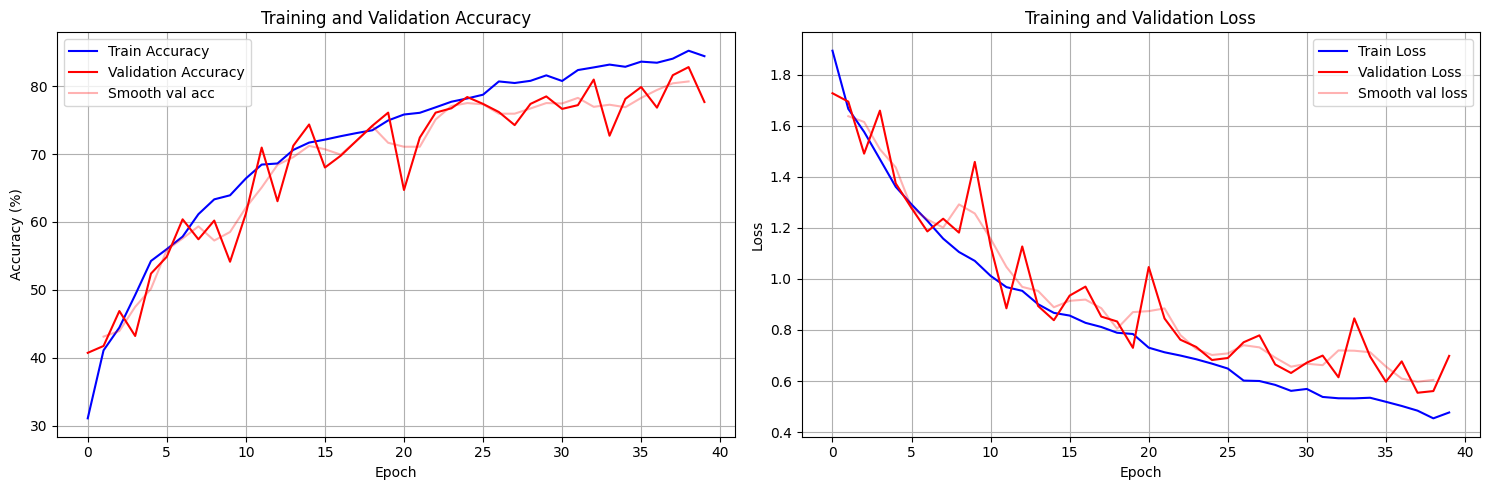

In [14]:
plot_training_history(history_resnet)

**Результы обучения resnet:** на 33 эпохе модель достигла Val Accuracy 90.73%

## Часть 2. Базовая U-Net на "Луне"

### Загрузка данных датасета


In [15]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)

        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)

        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

In [16]:
# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3818673436.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [17]:
# Путь к данным
DATA_ROOT = "MOON_SEGMENTATION_BINARY"
zip_path = f'{DATA_ROOT}.zip'
temp_extract = "./_temp_extract"

In [18]:
if not os.path.exists(DATA_ROOT):
    if not os.path.exists(zip_path):
        print(f"Файл {zip_path} не найден.")
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_extract)
            inner_folder = os.path.join(temp_extract, "MOON_SEGMENTATION_BINARY")

            os.makedirs(DATA_ROOT, exist_ok=True)
            for item in os.listdir(inner_folder):
                src = os.path.join(inner_folder, item)
                dst = os.path.join(DATA_ROOT, item)
                if os.path.isdir(src):
                    shutil.copytree(src, dst, dirs_exist_ok=True)
                else:
                    shutil.copy2(src, dst)
            shutil.rmtree(temp_extract)
            print(f"Архив {zip_path} успешно распакован в папку {DATA_ROOT}.")

Архив MOON_SEGMENTATION_BINARY.zip успешно распакован в папку MOON_SEGMENTATION_BINARY.


In [19]:
images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


### Модель

In [20]:
class LayerConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LayerConv, self).__init__()
        self.layer_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layer_conv(x)

In [21]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(LayerConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = LayerConv(features[-1], features[-1] * 2)

        in_channels_up = features[-1] * 2
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels_up, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                LayerConv(feature * 2, feature)
            )
            in_channels_up = feature


        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid())

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output

In [22]:
model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 2,466,657
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 192]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


### Скрипт обучения и метрики

In [23]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

    return dice.item()

def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

In [24]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(train_loader, desc="Training")

    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou

In [25]:
def validate_epoch(model, val_loader, criterion, device):

    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc

In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

### Обучение

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")
unet_model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5,patience=3,)

history = train_model(
    model=unet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_unet.pth'
)

  Используем устройство: cuda
Параметров: 2,466,657
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 192]
Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s, loss=0.8412, dice=0.2089, iou=0.1166, acc=0.8792]



 Результаты эпохи 1:
  Train - Loss: 0.8506, Dice: 0.2398, IoU: 0.1409
  Val   - Loss: 0.8435, Dice: 0.2413, IoU: 0.1375, Acc: 0.8832
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2413
Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s, loss=0.8243, dice=0.3559, iou=0.2165, acc=0.7790]



 Результаты эпохи 2:
  Train - Loss: 0.8342, Dice: 0.2722, IoU: 0.1678
  Val   - Loss: 0.8223, Dice: 0.3872, IoU: 0.2428, Acc: 0.7706
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3872
Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s, loss=0.8243, dice=0.3217, iou=0.1917, acc=0.5216]



 Результаты эпохи 3:
  Train - Loss: 0.8250, Dice: 0.2909, IoU: 0.1772
  Val   - Loss: 0.8381, Dice: 0.2905, IoU: 0.1709, Acc: 0.4882
  LR: 0.000100
Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s, loss=0.8049, dice=0.3662, iou=0.2242, acc=0.7210]



 Результаты эпохи 4:
  Train - Loss: 0.8156, Dice: 0.3278, IoU: 0.2033
  Val   - Loss: 0.8048, Dice: 0.3771, IoU: 0.2347, Acc: 0.7289
  LR: 0.000100
Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s, loss=0.7809, dice=0.4692, iou=0.3065, acc=0.8374]



 Результаты эпохи 5:
  Train - Loss: 0.8087, Dice: 0.3262, IoU: 0.1997
  Val   - Loss: 0.7881, Dice: 0.4522, IoU: 0.2928, Acc: 0.8350
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4522
Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s, loss=0.7733, dice=0.4715, iou=0.3085, acc=0.8657]



 Результаты эпохи 6:
  Train - Loss: 0.8034, Dice: 0.3490, IoU: 0.2173
  Val   - Loss: 0.7810, Dice: 0.4563, IoU: 0.2959, Acc: 0.8762
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4563
Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s, loss=0.7642, dice=0.4847, iou=0.3199, acc=0.8802]



 Результаты эпохи 7:
  Train - Loss: 0.7975, Dice: 0.3576, IoU: 0.2284
  Val   - Loss: 0.7716, Dice: 0.4774, IoU: 0.3144, Acc: 0.8792
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4774
Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.20it/s, loss=0.8004, dice=0.3571, iou=0.2174, acc=0.6546]



 Результаты эпохи 8:
  Train - Loss: 0.7967, Dice: 0.3516, IoU: 0.2196
  Val   - Loss: 0.8055, Dice: 0.3543, IoU: 0.2166, Acc: 0.6620
  LR: 0.000100
Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s, loss=0.7566, dice=0.5015, iou=0.3347, acc=0.8618]



 Результаты эпохи 9:
  Train - Loss: 0.7876, Dice: 0.3756, IoU: 0.2362
  Val   - Loss: 0.7692, Dice: 0.4736, IoU: 0.3113, Acc: 0.8605
  LR: 0.000100
Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s, loss=0.8235, dice=0.2990, iou=0.1758, acc=0.5503]



 Результаты эпохи 10:
  Train - Loss: 0.7837, Dice: 0.3893, IoU: 0.2499
  Val   - Loss: 0.8183, Dice: 0.3208, IoU: 0.1927, Acc: 0.5986
  LR: 0.000100
Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s, loss=0.7613, dice=0.4522, iou=0.2922, acc=0.8881]



 Результаты эпохи 11:
  Train - Loss: 0.7808, Dice: 0.3931, IoU: 0.2506
  Val   - Loss: 0.7722, Dice: 0.4238, IoU: 0.2702, Acc: 0.8923
  LR: 0.000050
Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s, loss=0.7509, dice=0.5056, iou=0.3383, acc=0.8446]



 Результаты эпохи 12:
  Train - Loss: 0.7836, Dice: 0.3737, IoU: 0.2373
  Val   - Loss: 0.7623, Dice: 0.4765, IoU: 0.3147, Acc: 0.8314
  LR: 0.000050
Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s, loss=0.7525, dice=0.4947, iou=0.3287, acc=0.8515]



 Результаты эпохи 13:
  Train - Loss: 0.7706, Dice: 0.4209, IoU: 0.2742
  Val   - Loss: 0.7611, Dice: 0.4774, IoU: 0.3153, Acc: 0.8505
  LR: 0.000050
Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s, loss=0.7353, dice=0.5361, iou=0.3662, acc=0.8710]



 Результаты эпохи 14:
  Train - Loss: 0.7795, Dice: 0.3799, IoU: 0.2424
  Val   - Loss: 0.7501, Dice: 0.5015, IoU: 0.3357, Acc: 0.8695
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5015
Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s, loss=0.7480, dice=0.5056, iou=0.3384, acc=0.8793]



 Результаты эпохи 15:
  Train - Loss: 0.7721, Dice: 0.4044, IoU: 0.2617
  Val   - Loss: 0.7550, Dice: 0.4952, IoU: 0.3313, Acc: 0.8741
  LR: 0.000050
Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=0.7235, dice=0.5871, iou=0.4156, acc=0.8871]



 Результаты эпохи 16:
  Train - Loss: 0.7714, Dice: 0.4063, IoU: 0.2631
  Val   - Loss: 0.7455, Dice: 0.5092, IoU: 0.3431, Acc: 0.8742
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5092
Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.7442, dice=0.4910, iou=0.3254, acc=0.8190]



 Результаты эпохи 17:
  Train - Loss: 0.7634, Dice: 0.4262, IoU: 0.2781
  Val   - Loss: 0.7561, Dice: 0.4610, IoU: 0.3017, Acc: 0.8051
  LR: 0.000050
Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s, loss=0.7217, dice=0.5811, iou=0.4095, acc=0.8814]



 Результаты эпохи 18:
  Train - Loss: 0.7651, Dice: 0.4305, IoU: 0.2830
  Val   - Loss: 0.7425, Dice: 0.5087, IoU: 0.3425, Acc: 0.8727
  LR: 0.000050
Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s, loss=0.7218, dice=0.5714, iou=0.4000, acc=0.8829]



 Результаты эпохи 19:
  Train - Loss: 0.7701, Dice: 0.3978, IoU: 0.2566
  Val   - Loss: 0.7389, Dice: 0.5179, IoU: 0.3504, Acc: 0.8739
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5179
Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s, loss=0.7257, dice=0.5569, iou=0.3859, acc=0.8778]



 Результаты эпохи 20:
  Train - Loss: 0.7678, Dice: 0.4026, IoU: 0.2599
  Val   - Loss: 0.7376, Dice: 0.5234, IoU: 0.3562, Acc: 0.8758
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5234
Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s, loss=0.7131, dice=0.5852, iou=0.4136, acc=0.8760]



 Результаты эпохи 21:
  Train - Loss: 0.7689, Dice: 0.3913, IoU: 0.2547
  Val   - Loss: 0.7374, Dice: 0.5039, IoU: 0.3385, Acc: 0.8678
  LR: 0.000050
Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.82it/s, loss=0.7054, dice=0.6033, iou=0.4319, acc=0.8927]



 Результаты эпохи 22:
  Train - Loss: 0.7656, Dice: 0.4053, IoU: 0.2644
  Val   - Loss: 0.7275, Dice: 0.5293, IoU: 0.3616, Acc: 0.8750
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5293
Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s, loss=0.7181, dice=0.5597, iou=0.3886, acc=0.8672]



 Результаты эпохи 23:
  Train - Loss: 0.7603, Dice: 0.4164, IoU: 0.2728
  Val   - Loss: 0.7362, Dice: 0.4999, IoU: 0.3340, Acc: 0.8587
  LR: 0.000050
Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.42it/s, loss=0.7204, dice=0.5568, iou=0.3858, acc=0.8449]



 Результаты эпохи 24:
  Train - Loss: 0.7587, Dice: 0.4188, IoU: 0.2765
  Val   - Loss: 0.7396, Dice: 0.4874, IoU: 0.3245, Acc: 0.8215
  LR: 0.000050
Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s, loss=0.7124, dice=0.5950, iou=0.4235, acc=0.8805]



 Результаты эпохи 25:
  Train - Loss: 0.7600, Dice: 0.4218, IoU: 0.2715
  Val   - Loss: 0.7318, Dice: 0.5201, IoU: 0.3530, Acc: 0.8657
  LR: 0.000050
Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.61it/s, loss=0.7170, dice=0.5472, iou=0.3767, acc=0.8646]



 Результаты эпохи 26:
  Train - Loss: 0.7561, Dice: 0.4242, IoU: 0.2802
  Val   - Loss: 0.7339, Dice: 0.4982, IoU: 0.3330, Acc: 0.8525
  LR: 0.000025
Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s, loss=0.7069, dice=0.5744, iou=0.4029, acc=0.8748]



 Результаты эпохи 27:
  Train - Loss: 0.7624, Dice: 0.4018, IoU: 0.2622
  Val   - Loss: 0.7279, Dice: 0.5083, IoU: 0.3417, Acc: 0.8622
  LR: 0.000025
Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.72it/s, loss=0.7111, dice=0.5636, iou=0.3924, acc=0.8791]



 Результаты эпохи 28:
  Train - Loss: 0.7490, Dice: 0.4492, IoU: 0.2922
  Val   - Loss: 0.7267, Dice: 0.5161, IoU: 0.3487, Acc: 0.8692
  LR: 0.000025
Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s, loss=0.7067, dice=0.5888, iou=0.4172, acc=0.8731]



 Результаты эпохи 29:
  Train - Loss: 0.7526, Dice: 0.4310, IoU: 0.2821
  Val   - Loss: 0.7272, Dice: 0.5188, IoU: 0.3514, Acc: 0.8639
  LR: 0.000025
Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.52it/s, loss=0.6992, dice=0.5910, iou=0.4194, acc=0.8816]



 Результаты эпохи 30:
  Train - Loss: 0.7575, Dice: 0.4115, IoU: 0.2676
  Val   - Loss: 0.7242, Dice: 0.5156, IoU: 0.3488, Acc: 0.8768
  LR: 0.000013
Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s, loss=0.7024, dice=0.5923, iou=0.4208, acc=0.8727]



 Результаты эпохи 31:
  Train - Loss: 0.7523, Dice: 0.4303, IoU: 0.2843
  Val   - Loss: 0.7262, Dice: 0.5114, IoU: 0.3448, Acc: 0.8569
  LR: 0.000013
Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s, loss=0.6887, dice=0.6024, iou=0.4310, acc=0.8772]



 Результаты эпохи 32:
  Train - Loss: 0.7578, Dice: 0.4108, IoU: 0.2665
  Val   - Loss: 0.7161, Dice: 0.5221, IoU: 0.3547, Acc: 0.8632
  LR: 0.000013
Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.7014, dice=0.6104, iou=0.4392, acc=0.8815]



 Результаты эпохи 33:
  Train - Loss: 0.7393, Dice: 0.4729, IoU: 0.3160
  Val   - Loss: 0.7242, Dice: 0.5249, IoU: 0.3575, Acc: 0.8630
  LR: 0.000013
Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s, loss=0.7019, dice=0.6078, iou=0.4366, acc=0.8782]



 Результаты эпохи 34:
  Train - Loss: 0.7435, Dice: 0.4648, IoU: 0.3085
  Val   - Loss: 0.7252, Dice: 0.5220, IoU: 0.3549, Acc: 0.8597
  LR: 0.000006
Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s, loss=0.6933, dice=0.6063, iou=0.4350, acc=0.8906]



 Результаты эпохи 35:
  Train - Loss: 0.7582, Dice: 0.4120, IoU: 0.2705
  Val   - Loss: 0.7161, Dice: 0.5346, IoU: 0.3659, Acc: 0.8845
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.5346
Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s, loss=0.6924, dice=0.6052, iou=0.4339, acc=0.8836]



 Результаты эпохи 36:
  Train - Loss: 0.7480, Dice: 0.4380, IoU: 0.2913
  Val   - Loss: 0.7167, Dice: 0.5276, IoU: 0.3597, Acc: 0.8760
  LR: 0.000006
Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.6929, dice=0.6023, iou=0.4310, acc=0.8758]



 Результаты эпохи 37:
  Train - Loss: 0.7487, Dice: 0.4416, IoU: 0.2902
  Val   - Loss: 0.7186, Dice: 0.5217, IoU: 0.3543, Acc: 0.8663
  LR: 0.000006
Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s, loss=0.6916, dice=0.6072, iou=0.4359, acc=0.8830]



 Результаты эпохи 38:
  Train - Loss: 0.7411, Dice: 0.4629, IoU: 0.3127
  Val   - Loss: 0.7168, Dice: 0.5312, IoU: 0.3627, Acc: 0.8770
  LR: 0.000006
Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s, loss=0.6934, dice=0.6031, iou=0.4318, acc=0.8779]



 Результаты эпохи 39:
  Train - Loss: 0.7478, Dice: 0.4454, IoU: 0.2964
  Val   - Loss: 0.7167, Dice: 0.5268, IoU: 0.3587, Acc: 0.8666
  LR: 0.000003
Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s, loss=0.6941, dice=0.6078, iou=0.4366, acc=0.8852]



 Результаты эпохи 40:
  Train - Loss: 0.7474, Dice: 0.4446, IoU: 0.2980
  Val   - Loss: 0.7167, Dice: 0.5305, IoU: 0.3622, Acc: 0.8743
  LR: 0.000003
Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s, loss=0.6879, dice=0.6096, iou=0.4384, acc=0.8879]



 Результаты эпохи 41:
  Train - Loss: 0.7546, Dice: 0.4176, IoU: 0.2716
  Val   - Loss: 0.7116, Dice: 0.5355, IoU: 0.3666, Acc: 0.8806
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.5355
Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s, loss=0.6916, dice=0.6030, iou=0.4316, acc=0.8831]



 Результаты эпохи 42:
  Train - Loss: 0.7542, Dice: 0.4219, IoU: 0.2786
  Val   - Loss: 0.7142, Dice: 0.5280, IoU: 0.3597, Acc: 0.8718
  LR: 0.000003
Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.94it/s, loss=0.6900, dice=0.6051, iou=0.4338, acc=0.8878]



 Результаты эпохи 43:
  Train - Loss: 0.7472, Dice: 0.4440, IoU: 0.2919
  Val   - Loss: 0.7139, Dice: 0.5336, IoU: 0.3648, Acc: 0.8825
  LR: 0.000003
Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s, loss=0.6886, dice=0.6112, iou=0.4401, acc=0.8858]



 Результаты эпохи 44:
  Train - Loss: 0.7392, Dice: 0.4717, IoU: 0.3150
  Val   - Loss: 0.7140, Dice: 0.5341, IoU: 0.3654, Acc: 0.8784
  LR: 0.000003
Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s, loss=0.6875, dice=0.6028, iou=0.4315, acc=0.8806]



 Результаты эпохи 45:
  Train - Loss: 0.7479, Dice: 0.4353, IoU: 0.2885
  Val   - Loss: 0.7146, Dice: 0.5285, IoU: 0.3604, Acc: 0.8728
  LR: 0.000002
Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s, loss=0.6866, dice=0.5988, iou=0.4274, acc=0.8777]



 Результаты эпохи 46:
  Train - Loss: 0.7600, Dice: 0.4023, IoU: 0.2637
  Val   - Loss: 0.7128, Dice: 0.5261, IoU: 0.3582, Acc: 0.8711
  LR: 0.000002
Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s, loss=0.6961, dice=0.6059, iou=0.4346, acc=0.8794]



 Результаты эпохи 47:
  Train - Loss: 0.7482, Dice: 0.4392, IoU: 0.2929
  Val   - Loss: 0.7191, Dice: 0.5258, IoU: 0.3579, Acc: 0.8668
  LR: 0.000002
Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.28it/s, loss=0.6873, dice=0.6081, iou=0.4369, acc=0.8792]



 Результаты эпохи 48:
  Train - Loss: 0.7548, Dice: 0.4213, IoU: 0.2738
  Val   - Loss: 0.7145, Dice: 0.5263, IoU: 0.3583, Acc: 0.8671
  LR: 0.000002
Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s, loss=0.6854, dice=0.6061, iou=0.4348, acc=0.8813]



 Результаты эпохи 49:
  Train - Loss: 0.7424, Dice: 0.4537, IoU: 0.2999
  Val   - Loss: 0.7129, Dice: 0.5298, IoU: 0.3615, Acc: 0.8744
  LR: 0.000001
Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s, loss=0.6895, dice=0.6092, iou=0.4380, acc=0.8906]



 Результаты эпохи 50:
  Train - Loss: 0.7505, Dice: 0.4327, IoU: 0.2837
  Val   - Loss: 0.7145, Dice: 0.5331, IoU: 0.3646, Acc: 0.8835
  LR: 0.000001
Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s, loss=0.6890, dice=0.6090, iou=0.4379, acc=0.8902]



 Результаты эпохи 51:
  Train - Loss: 0.7421, Dice: 0.4551, IoU: 0.3053
  Val   - Loss: 0.7135, Dice: 0.5296, IoU: 0.3614, Acc: 0.8848
  LR: 0.000001
Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s, loss=0.6884, dice=0.6056, iou=0.4343, acc=0.8789]



 Результаты эпохи 52:
  Train - Loss: 0.7459, Dice: 0.4492, IoU: 0.2991
  Val   - Loss: 0.7159, Dice: 0.5268, IoU: 0.3587, Acc: 0.8705
  LR: 0.000001
Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.09it/s, loss=0.6907, dice=0.6087, iou=0.4375, acc=0.8836]



 Результаты эпохи 53:
  Train - Loss: 0.7405, Dice: 0.4610, IoU: 0.3093
  Val   - Loss: 0.7173, Dice: 0.5292, IoU: 0.3611, Acc: 0.8727
  LR: 0.000000
Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s, loss=0.6906, dice=0.6029, iou=0.4315, acc=0.8816]



 Результаты эпохи 54:
  Train - Loss: 0.7521, Dice: 0.4255, IoU: 0.2779
  Val   - Loss: 0.7166, Dice: 0.5276, IoU: 0.3598, Acc: 0.8730
  LR: 0.000000
Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s, loss=0.6934, dice=0.6068, iou=0.4355, acc=0.8795]



 Результаты эпохи 55:
  Train - Loss: 0.7440, Dice: 0.4555, IoU: 0.3026
  Val   - Loss: 0.7184, Dice: 0.5248, IoU: 0.3571, Acc: 0.8673
  LR: 0.000000
Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s, loss=0.6920, dice=0.6040, iou=0.4327, acc=0.8824]



 Результаты эпохи 56:
  Train - Loss: 0.7389, Dice: 0.4726, IoU: 0.3151
  Val   - Loss: 0.7177, Dice: 0.5275, IoU: 0.3596, Acc: 0.8749
  LR: 0.000000
Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s, loss=0.6902, dice=0.6048, iou=0.4335, acc=0.8839]



 Результаты эпохи 57:
  Train - Loss: 0.7396, Dice: 0.4738, IoU: 0.3188
  Val   - Loss: 0.7165, Dice: 0.5289, IoU: 0.3608, Acc: 0.8772
  LR: 0.000000
Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s, loss=0.6915, dice=0.6109, iou=0.4398, acc=0.8876]



 Результаты эпохи 58:
  Train - Loss: 0.7480, Dice: 0.4318, IoU: 0.2876
  Val   - Loss: 0.7162, Dice: 0.5330, IoU: 0.3644, Acc: 0.8802
  LR: 0.000000
Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.20it/s, loss=0.6858, dice=0.6114, iou=0.4403, acc=0.8842]



 Результаты эпохи 59:
  Train - Loss: 0.7532, Dice: 0.4182, IoU: 0.2728
  Val   - Loss: 0.7122, Dice: 0.5324, IoU: 0.3639, Acc: 0.8753
  LR: 0.000000
Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.89it/s, loss=0.6866, dice=0.6108, iou=0.4397, acc=0.8820]


 Результаты эпохи 60:
  Train - Loss: 0.7486, Dice: 0.4338, IoU: 0.2861
  Val   - Loss: 0.7138, Dice: 0.5287, IoU: 0.3605, Acc: 0.8706
  LR: 0.000000
Лучший Val Dice: 0.5355


**Результы обучения unet:** на 41 эпохе модель достигла на валидации Dice = 0.5355, IoU = 0.3666, Pixel Acc = 0.8806

### Визуализация

In [28]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

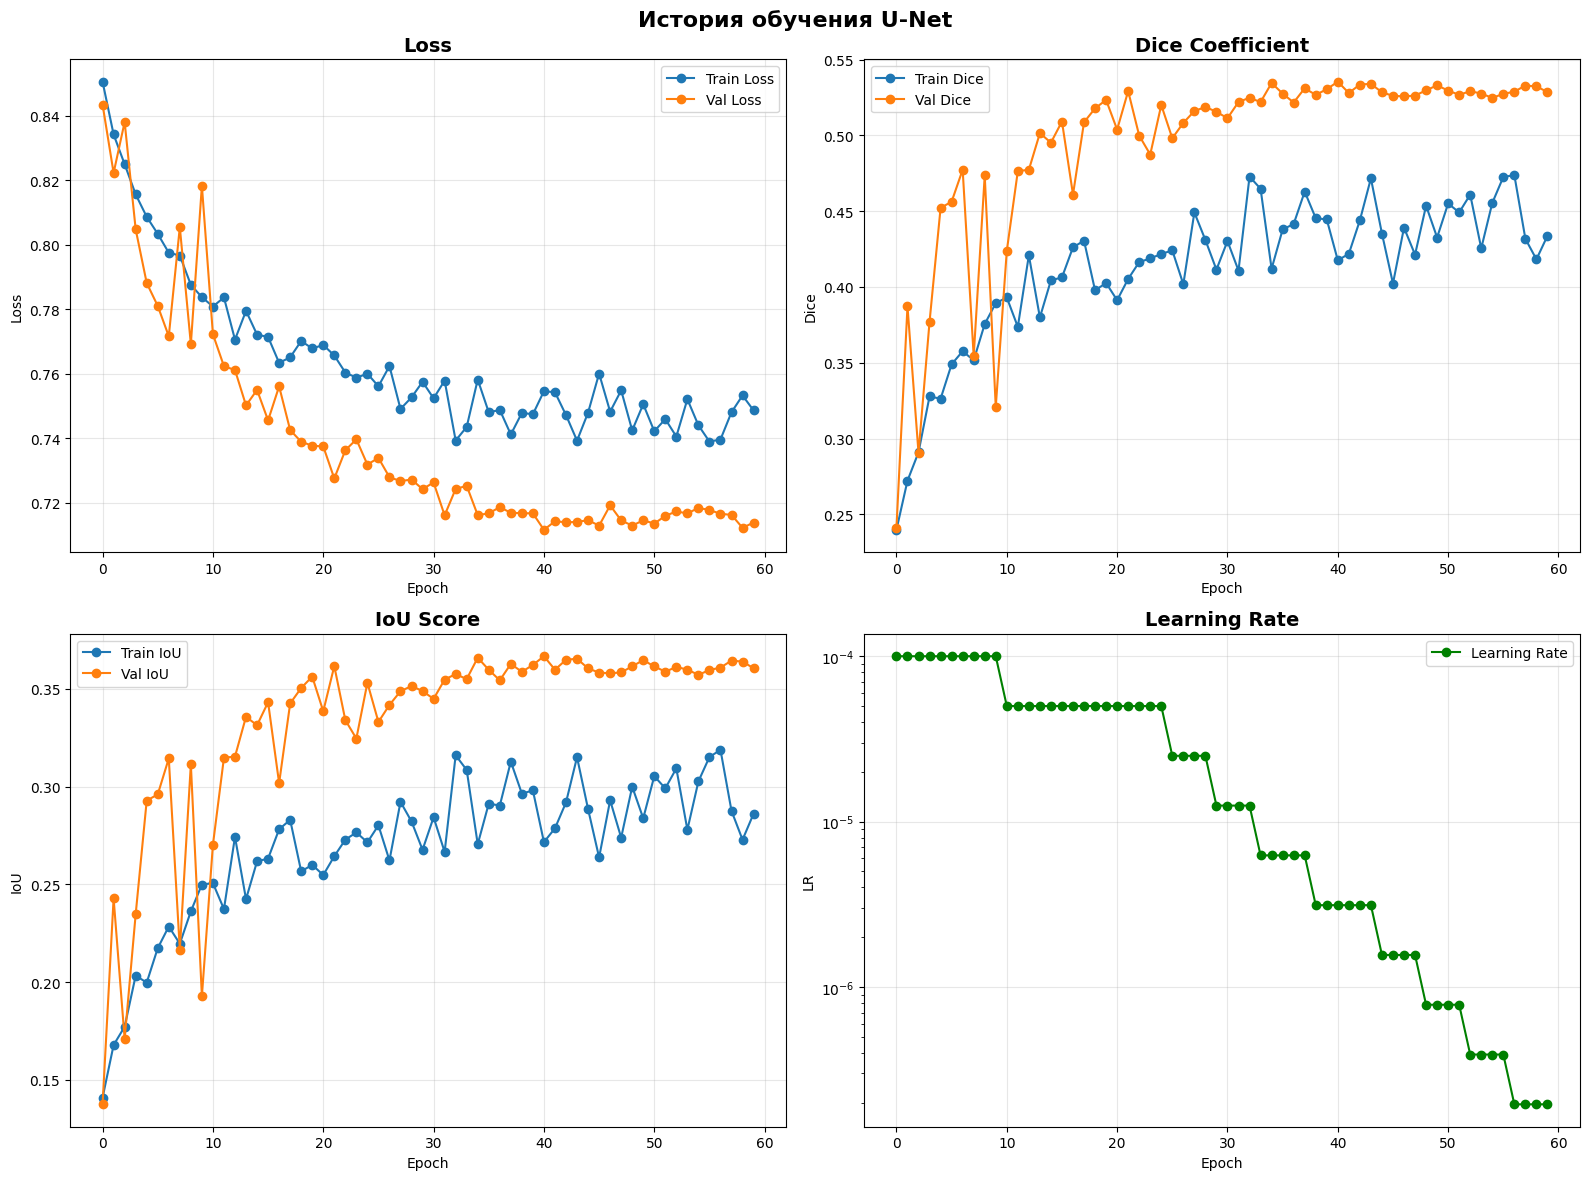

Train Loss: 0.7486
Val Loss: 0.7138
Train Dice: 0.4338
Val Dice: 0.5287
Train IoU: 0.2861
Val IoU: 0.3605
Val Accuracy: 0.8706


In [66]:
plot_training_history(history)

In [32]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')

        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')

        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])


        axes[i, 3].text(
            0.5, -0.15,
            f'Dice: {dice:.4f}   |   IoU: {iou:.4f}',
            transform=axes[i, 3].transAxes,
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="none")
        )

    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

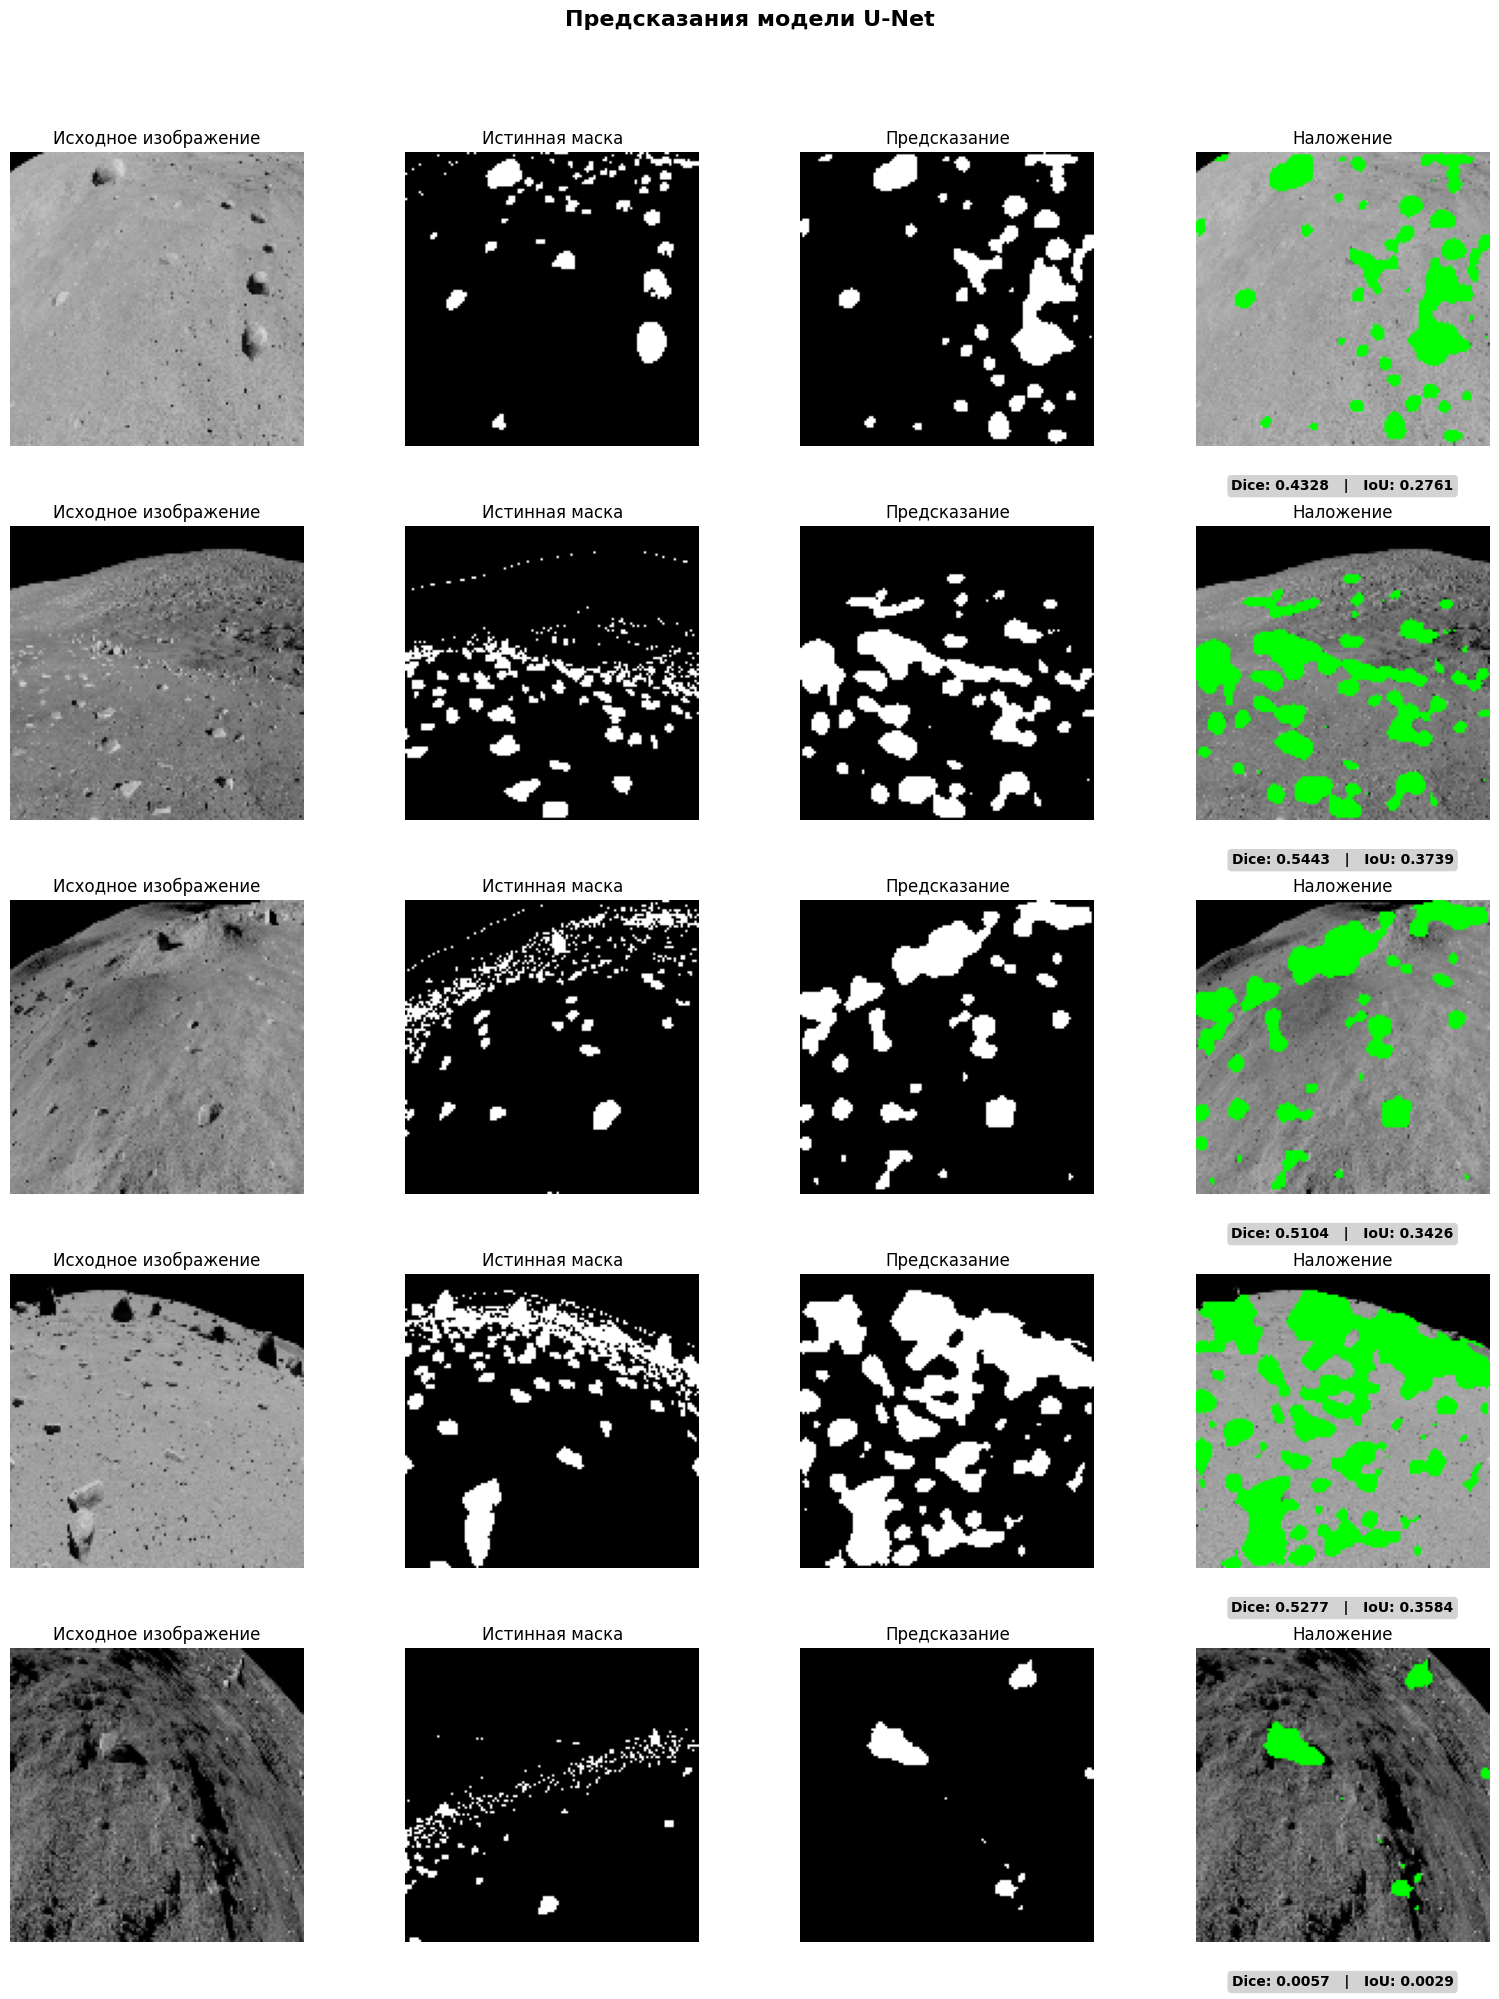

In [67]:
visualize_predictions(unet_model, val_loader, device, num_samples=5)

## Часть 3. U-Net с бэкбоном из классификатора

### Модель

In [35]:
class ResNetUNet(nn.Module):

    def __init__(self, out_channels=1, features=[32, 64, 128, 256], state_dict=None):
        super(ResNetUNet, self).__init__()

        resnet = ModelResnet()
        resnet.load_state_dict(state_dict)

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_blocks.append(resnet.basic_block_1_0) #32 канала
        self.encoder_blocks.append(resnet.basic_block_2_0) #64 каналов
        self.encoder_blocks.append(resnet.basic_block_3_0) #128 каналов
        self.encoder_blocks.append(resnet.basic_block_4_0) #256 каналов

        self.bottleneck = LayerConv(features[-1], features[-1] * 2)

        in_channels_up = features[-1] * 2
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels_up, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                LayerConv(feature * 2, feature)
            )
            in_channels_up = feature


        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid())

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):
        skip_connections = []
        for i, encoder_block in enumerate(self.encoder_blocks):
            x = encoder_block(x)
            skip_connections.append(x)
            if i == 0:
             x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output

In [68]:
resnet_unet = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth"))
for param in resnet_unet.encoder_blocks.parameters():
  param.requires_grad = False

test_input = torch.randn(1, 3, 128, 128)
test_output = resnet_unet(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in resnet_unet.parameters())
trainable_params = sum(p.numel() for p in resnet_unet.parameters() if p.requires_grad)

print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых параметров: {trainable_params:,}")

Параметров: 4,663,457
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])
   Всего параметров: 4,663,457
   Обучаемых параметров: 3,446,177


### Обучение

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")
resnet_unetA = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth"))
for param in resnet_unetA.encoder_blocks.parameters():
  param.requires_grad = False

print(f"   Обучаемых параметров: {sum(p.numel() for p in resnet_unetA.parameters() if p.requires_grad):,}")
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(resnet_unetA.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_resnet_unet_A = train_model(
    model=resnet_unetA,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_resnet_unet_A.pth'
)

  Используем устройство: cuda
Параметров: 4,663,457
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Обучаемых параметров: 3,446,177
Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.22it/s, loss=0.8444, dice=0.3358, iou=0.2018, acc=0.6158]



 Результаты эпохи 1:
  Train - Loss: 0.8729, Dice: 0.2116, IoU: 0.1201
  Val   - Loss: 0.8531, Dice: 0.3210, IoU: 0.1925, Acc: 0.6240
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3210
Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.56it/s, loss=0.8246, dice=0.3234, iou=0.1929, acc=0.5288]



 Результаты эпохи 2:
  Train - Loss: 0.8515, Dice: 0.2775, IoU: 0.1673
  Val   - Loss: 0.8360, Dice: 0.3183, IoU: 0.1900, Acc: 0.5602
  LR: 0.000100
Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s, loss=0.7803, dice=0.4443, iou=0.2856, acc=0.7467]



 Результаты эпохи 3:
  Train - Loss: 0.8380, Dice: 0.2978, IoU: 0.1813
  Val   - Loss: 0.7968, Dice: 0.3960, IoU: 0.2486, Acc: 0.7465
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3960
Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s, loss=0.7871, dice=0.4052, iou=0.2541, acc=0.6811]



 Результаты эпохи 4:
  Train - Loss: 0.8252, Dice: 0.3111, IoU: 0.1900
  Val   - Loss: 0.7929, Dice: 0.3875, IoU: 0.2408, Acc: 0.7341
  LR: 0.000100
Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s, loss=0.7669, dice=0.4675, iou=0.3050, acc=0.7726]



 Результаты эпохи 5:
  Train - Loss: 0.8161, Dice: 0.3302, IoU: 0.2045
  Val   - Loss: 0.7884, Dice: 0.4024, IoU: 0.2546, Acc: 0.7586
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4024
Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s, loss=0.7671, dice=0.4644, iou=0.3024, acc=0.7588]



 Результаты эпохи 6:
  Train - Loss: 0.8100, Dice: 0.3405, IoU: 0.2156
  Val   - Loss: 0.7878, Dice: 0.4027, IoU: 0.2545, Acc: 0.7488
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4027
Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.7685, dice=0.4557, iou=0.2951, acc=0.7504]



 Результаты эпохи 7:
  Train - Loss: 0.8068, Dice: 0.3440, IoU: 0.2154
  Val   - Loss: 0.7878, Dice: 0.3982, IoU: 0.2512, Acc: 0.7413
  LR: 0.000100
Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s, loss=0.7511, dice=0.5095, iou=0.3418, acc=0.8211]



 Результаты эпохи 8:
  Train - Loss: 0.8056, Dice: 0.3474, IoU: 0.2203
  Val   - Loss: 0.7709, Dice: 0.4505, IoU: 0.2924, Acc: 0.8167
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4505
Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s, loss=0.7560, dice=0.4864, iou=0.3213, acc=0.7761]



 Результаты эпохи 9:
  Train - Loss: 0.7964, Dice: 0.3705, IoU: 0.2370
  Val   - Loss: 0.7715, Dice: 0.4342, IoU: 0.2789, Acc: 0.7883
  LR: 0.000100
Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s, loss=0.7489, dice=0.5001, iou=0.3334, acc=0.8081]



 Результаты эпохи 10:
  Train - Loss: 0.7917, Dice: 0.3857, IoU: 0.2444
  Val   - Loss: 0.7596, Dice: 0.4705, IoU: 0.3083, Acc: 0.8356
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4705
Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s, loss=0.7531, dice=0.4938, iou=0.3278, acc=0.7898]



 Результаты эпохи 11:
  Train - Loss: 0.7931, Dice: 0.3755, IoU: 0.2403
  Val   - Loss: 0.7639, Dice: 0.4590, IoU: 0.2986, Acc: 0.8150
  LR: 0.000100
Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.31it/s, loss=0.7386, dice=0.5161, iou=0.3478, acc=0.8324]



 Результаты эпохи 12:
  Train - Loss: 0.7962, Dice: 0.3596, IoU: 0.2257
  Val   - Loss: 0.7505, Dice: 0.4832, IoU: 0.3191, Acc: 0.8447
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4832
Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s, loss=0.7506, dice=0.4938, iou=0.3279, acc=0.7860]



 Результаты эпохи 13:
  Train - Loss: 0.7867, Dice: 0.3906, IoU: 0.2481
  Val   - Loss: 0.7642, Dice: 0.4422, IoU: 0.2861, Acc: 0.7812
  LR: 0.000100
Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s, loss=0.7391, dice=0.5262, iou=0.3571, acc=0.8283]



 Результаты эпохи 14:
  Train - Loss: 0.7827, Dice: 0.3986, IoU: 0.2550
  Val   - Loss: 0.7607, Dice: 0.4480, IoU: 0.2922, Acc: 0.7995
  LR: 0.000100
Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s, loss=0.7499, dice=0.5095, iou=0.3418, acc=0.8070]



 Результаты эпохи 15:
  Train - Loss: 0.7802, Dice: 0.4041, IoU: 0.2617
  Val   - Loss: 0.7660, Dice: 0.4488, IoU: 0.2915, Acc: 0.8020
  LR: 0.000100
Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s, loss=0.7424, dice=0.4962, iou=0.3299, acc=0.7878]



 Результаты эпохи 16:
  Train - Loss: 0.7953, Dice: 0.3459, IoU: 0.2204
  Val   - Loss: 0.7565, Dice: 0.4548, IoU: 0.2953, Acc: 0.8109
  LR: 0.000050
Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.31it/s, loss=0.7472, dice=0.5162, iou=0.3479, acc=0.8138]



 Результаты эпохи 17:
  Train - Loss: 0.7721, Dice: 0.4239, IoU: 0.2765
  Val   - Loss: 0.7682, Dice: 0.4546, IoU: 0.2961, Acc: 0.7981
  LR: 0.000050
Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s, loss=0.7316, dice=0.5369, iou=0.3669, acc=0.8404]



 Результаты эпохи 18:
  Train - Loss: 0.7817, Dice: 0.3893, IoU: 0.2532
  Val   - Loss: 0.7522, Dice: 0.4711, IoU: 0.3102, Acc: 0.8251
  LR: 0.000050
Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s, loss=0.7373, dice=0.5211, iou=0.3523, acc=0.8148]



 Результаты эпохи 19:
  Train - Loss: 0.7719, Dice: 0.4170, IoU: 0.2738
  Val   - Loss: 0.7575, Dice: 0.4533, IoU: 0.2957, Acc: 0.8016
  LR: 0.000050
Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.14it/s, loss=0.7295, dice=0.5388, iou=0.3687, acc=0.8375]



 Результаты эпохи 20:
  Train - Loss: 0.7749, Dice: 0.4052, IoU: 0.2629
  Val   - Loss: 0.7487, Dice: 0.4777, IoU: 0.3161, Acc: 0.8350
  LR: 0.000025
Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.7395, dice=0.5295, iou=0.3600, acc=0.8237]



 Результаты эпохи 21:
  Train - Loss: 0.7749, Dice: 0.4088, IoU: 0.2628
  Val   - Loss: 0.7564, Dice: 0.4742, IoU: 0.3124, Acc: 0.8238
  LR: 0.000025
Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s, loss=0.7380, dice=0.5218, iou=0.3530, acc=0.8137]



 Результаты эпохи 22:
  Train - Loss: 0.7736, Dice: 0.4140, IoU: 0.2721
  Val   - Loss: 0.7533, Dice: 0.4730, IoU: 0.3109, Acc: 0.8287
  LR: 0.000025
Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s, loss=0.7385, dice=0.5348, iou=0.3650, acc=0.8254]



 Результаты эпохи 23:
  Train - Loss: 0.7690, Dice: 0.4166, IoU: 0.2722
  Val   - Loss: 0.7539, Dice: 0.4860, IoU: 0.3221, Acc: 0.8376
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4860
Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s, loss=0.7342, dice=0.5526, iou=0.3818, acc=0.8454]



 Результаты эпохи 24:
  Train - Loss: 0.7661, Dice: 0.4336, IoU: 0.2862
  Val   - Loss: 0.7488, Dice: 0.4993, IoU: 0.3342, Acc: 0.8548
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4993
Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.76it/s, loss=0.7256, dice=0.5577, iou=0.3867, acc=0.8529]



 Результаты эпохи 25:
  Train - Loss: 0.7679, Dice: 0.4255, IoU: 0.2799
  Val   - Loss: 0.7425, Dice: 0.5017, IoU: 0.3360, Acc: 0.8656
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.5017
Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s, loss=0.7213, dice=0.5541, iou=0.3832, acc=0.8425]



 Результаты эпохи 26:
  Train - Loss: 0.7684, Dice: 0.4201, IoU: 0.2714
  Val   - Loss: 0.7418, Dice: 0.4922, IoU: 0.3278, Acc: 0.8520
  LR: 0.000025
Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s, loss=0.7249, dice=0.5574, iou=0.3864, acc=0.8513]



 Результаты эпохи 27:
  Train - Loss: 0.7769, Dice: 0.3884, IoU: 0.2482
  Val   - Loss: 0.7458, Dice: 0.4900, IoU: 0.3262, Acc: 0.8528
  LR: 0.000025
Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s, loss=0.7271, dice=0.5532, iou=0.3824, acc=0.8458]



 Результаты эпохи 28:
  Train - Loss: 0.7676, Dice: 0.4282, IoU: 0.2785
  Val   - Loss: 0.7477, Dice: 0.4848, IoU: 0.3215, Acc: 0.8492
  LR: 0.000025
Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.38it/s, loss=0.7192, dice=0.5596, iou=0.3885, acc=0.8542]



 Результаты эпохи 29:
  Train - Loss: 0.7710, Dice: 0.4107, IoU: 0.2676
  Val   - Loss: 0.7403, Dice: 0.4911, IoU: 0.3270, Acc: 0.8609
  LR: 0.000013
Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s, loss=0.7294, dice=0.5487, iou=0.3781, acc=0.8384]



 Результаты эпохи 30:
  Train - Loss: 0.7656, Dice: 0.4243, IoU: 0.2774
  Val   - Loss: 0.7516, Dice: 0.4776, IoU: 0.3151, Acc: 0.8368
  LR: 0.000013
Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s, loss=0.7168, dice=0.5571, iou=0.3861, acc=0.8441]



 Результаты эпохи 31:
  Train - Loss: 0.7672, Dice: 0.4213, IoU: 0.2764
  Val   - Loss: 0.7375, Dice: 0.4926, IoU: 0.3280, Acc: 0.8526
  LR: 0.000013
Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s, loss=0.7217, dice=0.5584, iou=0.3873, acc=0.8461]



 Результаты эпохи 32:
  Train - Loss: 0.7699, Dice: 0.4198, IoU: 0.2729
  Val   - Loss: 0.7417, Dice: 0.4951, IoU: 0.3301, Acc: 0.8509
  LR: 0.000013
Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s, loss=0.7300, dice=0.5487, iou=0.3781, acc=0.8363]



 Результаты эпохи 33:
  Train - Loss: 0.7711, Dice: 0.4142, IoU: 0.2656
  Val   - Loss: 0.7500, Dice: 0.4875, IoU: 0.3236, Acc: 0.8353
  LR: 0.000006
Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.22it/s, loss=0.7200, dice=0.5558, iou=0.3848, acc=0.8434]



 Результаты эпохи 34:
  Train - Loss: 0.7663, Dice: 0.4291, IoU: 0.2803
  Val   - Loss: 0.7388, Dice: 0.4941, IoU: 0.3293, Acc: 0.8531
  LR: 0.000006
Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s, loss=0.7123, dice=0.5655, iou=0.3942, acc=0.8515]



 Результаты эпохи 35:
  Train - Loss: 0.7696, Dice: 0.4082, IoU: 0.2641
  Val   - Loss: 0.7324, Dice: 0.5039, IoU: 0.3380, Acc: 0.8615
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.5039
Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s, loss=0.7207, dice=0.5619, iou=0.3908, acc=0.8545]



 Результаты эпохи 36:
  Train - Loss: 0.7689, Dice: 0.4186, IoU: 0.2722
  Val   - Loss: 0.7380, Dice: 0.5057, IoU: 0.3394, Acc: 0.8671
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.5057
Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s, loss=0.7214, dice=0.5531, iou=0.3822, acc=0.8425]



 Результаты эпохи 37:
  Train - Loss: 0.7725, Dice: 0.4021, IoU: 0.2580
  Val   - Loss: 0.7382, Dice: 0.4940, IoU: 0.3292, Acc: 0.8564
  LR: 0.000006
Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s, loss=0.7295, dice=0.5508, iou=0.3801, acc=0.8403]



 Результаты эпохи 38:
  Train - Loss: 0.7629, Dice: 0.4333, IoU: 0.2875
  Val   - Loss: 0.7481, Dice: 0.4921, IoU: 0.3276, Acc: 0.8469
  LR: 0.000006
Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s, loss=0.7268, dice=0.5507, iou=0.3800, acc=0.8373]



 Результаты эпохи 39:
  Train - Loss: 0.7657, Dice: 0.4278, IoU: 0.2787
  Val   - Loss: 0.7453, Dice: 0.4935, IoU: 0.3285, Acc: 0.8455
  LR: 0.000006
Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s, loss=0.7226, dice=0.5613, iou=0.3901, acc=0.8478]



 Результаты эпохи 40:
  Train - Loss: 0.7639, Dice: 0.4322, IoU: 0.2843
  Val   - Loss: 0.7413, Dice: 0.5033, IoU: 0.3371, Acc: 0.8576
  LR: 0.000003
Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s, loss=0.7166, dice=0.5582, iou=0.3872, acc=0.8450]



 Результаты эпохи 41:
  Train - Loss: 0.7670, Dice: 0.4257, IoU: 0.2787
  Val   - Loss: 0.7369, Dice: 0.4969, IoU: 0.3317, Acc: 0.8502
  LR: 0.000003
Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.89it/s, loss=0.7209, dice=0.5603, iou=0.3891, acc=0.8478]



 Результаты эпохи 42:
  Train - Loss: 0.7644, Dice: 0.4297, IoU: 0.2817
  Val   - Loss: 0.7407, Dice: 0.5011, IoU: 0.3353, Acc: 0.8582
  LR: 0.000003
Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s, loss=0.7182, dice=0.5546, iou=0.3837, acc=0.8481]



 Результаты эпохи 43:
  Train - Loss: 0.7672, Dice: 0.4184, IoU: 0.2759
  Val   - Loss: 0.7373, Dice: 0.4943, IoU: 0.3294, Acc: 0.8595
  LR: 0.000003
Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s, loss=0.7162, dice=0.5570, iou=0.3860, acc=0.8452]



 Результаты эпохи 44:
  Train - Loss: 0.7675, Dice: 0.4149, IoU: 0.2716
  Val   - Loss: 0.7350, Dice: 0.5016, IoU: 0.3356, Acc: 0.8582
  LR: 0.000002
Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s, loss=0.7203, dice=0.5550, iou=0.3841, acc=0.8406]



 Результаты эпохи 45:
  Train - Loss: 0.7725, Dice: 0.3973, IoU: 0.2589
  Val   - Loss: 0.7398, Dice: 0.4942, IoU: 0.3291, Acc: 0.8496
  LR: 0.000002
Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s, loss=0.7154, dice=0.5655, iou=0.3942, acc=0.8515]



 Результаты эпохи 46:
  Train - Loss: 0.7718, Dice: 0.4075, IoU: 0.2647
  Val   - Loss: 0.7343, Dice: 0.5067, IoU: 0.3402, Acc: 0.8614
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.5067
Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s, loss=0.7204, dice=0.5540, iou=0.3831, acc=0.8454]



 Результаты эпохи 47:
  Train - Loss: 0.7639, Dice: 0.4305, IoU: 0.2827
  Val   - Loss: 0.7394, Dice: 0.4951, IoU: 0.3300, Acc: 0.8535
  LR: 0.000002
Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s, loss=0.7140, dice=0.5623, iou=0.3911, acc=0.8492]



 Результаты эпохи 48:
  Train - Loss: 0.7697, Dice: 0.4086, IoU: 0.2640
  Val   - Loss: 0.7327, Dice: 0.5042, IoU: 0.3379, Acc: 0.8608
  LR: 0.000002
Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s, loss=0.7196, dice=0.5602, iou=0.3891, acc=0.8458]



 Результаты эпохи 49:
  Train - Loss: 0.7668, Dice: 0.4196, IoU: 0.2772
  Val   - Loss: 0.7382, Dice: 0.5038, IoU: 0.3376, Acc: 0.8570
  LR: 0.000002
Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.99it/s, loss=0.7140, dice=0.5640, iou=0.3927, acc=0.8510]



 Результаты эпохи 50:
  Train - Loss: 0.7730, Dice: 0.3974, IoU: 0.2556
  Val   - Loss: 0.7329, Dice: 0.5054, IoU: 0.3391, Acc: 0.8621
  LR: 0.000001
Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s, loss=0.7176, dice=0.5574, iou=0.3864, acc=0.8428]



 Результаты эпохи 51:
  Train - Loss: 0.7623, Dice: 0.4304, IoU: 0.2834
  Val   - Loss: 0.7364, Dice: 0.4986, IoU: 0.3330, Acc: 0.8530
  LR: 0.000001
Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s, loss=0.7203, dice=0.5533, iou=0.3825, acc=0.8422]



 Результаты эпохи 52:
  Train - Loss: 0.7660, Dice: 0.4224, IoU: 0.2742
  Val   - Loss: 0.7393, Dice: 0.4971, IoU: 0.3317, Acc: 0.8546
  LR: 0.000001
Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.7165, dice=0.5640, iou=0.3927, acc=0.8522]



 Результаты эпохи 53:
  Train - Loss: 0.7559, Dice: 0.4598, IoU: 0.3038
  Val   - Loss: 0.7357, Dice: 0.5057, IoU: 0.3394, Acc: 0.8633
  LR: 0.000001
Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s, loss=0.7129, dice=0.5637, iou=0.3924, acc=0.8516]



 Результаты эпохи 54:
  Train - Loss: 0.7684, Dice: 0.4043, IoU: 0.2618
  Val   - Loss: 0.7317, Dice: 0.5064, IoU: 0.3400, Acc: 0.8621
  LR: 0.000000
Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.03it/s, loss=0.7103, dice=0.5650, iou=0.3938, acc=0.8605]



 Результаты эпохи 55:
  Train - Loss: 0.7640, Dice: 0.4281, IoU: 0.2831
  Val   - Loss: 0.7325, Dice: 0.5007, IoU: 0.3352, Acc: 0.8679
  LR: 0.000000
Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s, loss=0.7118, dice=0.5629, iou=0.3917, acc=0.8548]



 Результаты эпохи 56:
  Train - Loss: 0.7673, Dice: 0.4165, IoU: 0.2729
  Val   - Loss: 0.7317, Dice: 0.5024, IoU: 0.3365, Acc: 0.8645
  LR: 0.000000
Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.42it/s, loss=0.7209, dice=0.5456, iou=0.3751, acc=0.8339]



 Результаты эпохи 57:
  Train - Loss: 0.7678, Dice: 0.4216, IoU: 0.2747
  Val   - Loss: 0.7392, Dice: 0.4906, IoU: 0.3259, Acc: 0.8452
  LR: 0.000000
Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s, loss=0.7153, dice=0.5628, iou=0.3916, acc=0.8512]



 Результаты эпохи 58:
  Train - Loss: 0.7685, Dice: 0.4096, IoU: 0.2650
  Val   - Loss: 0.7346, Dice: 0.5021, IoU: 0.3362, Acc: 0.8621
  LR: 0.000000
Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s, loss=0.7184, dice=0.5652, iou=0.3940, acc=0.8525]



 Результаты эпохи 59:
  Train - Loss: 0.7723, Dice: 0.4020, IoU: 0.2599
  Val   - Loss: 0.7379, Dice: 0.5034, IoU: 0.3373, Acc: 0.8598
  LR: 0.000000
Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.91it/s, loss=0.7204, dice=0.5554, iou=0.3844, acc=0.8427]


 Результаты эпохи 60:
  Train - Loss: 0.7701, Dice: 0.4045, IoU: 0.2582
  Val   - Loss: 0.7378, Dice: 0.5001, IoU: 0.3342, Acc: 0.8566
  LR: 0.000000
Лучший Val Dice: 0.5067


**Результы обучения U-Net с бэкбоном из ResNet с заморозкой:** на 46 эпохе модель достигла на валидации Dice = 0.5067, IoU = 0.3402, Pixel Acc = 0.8614

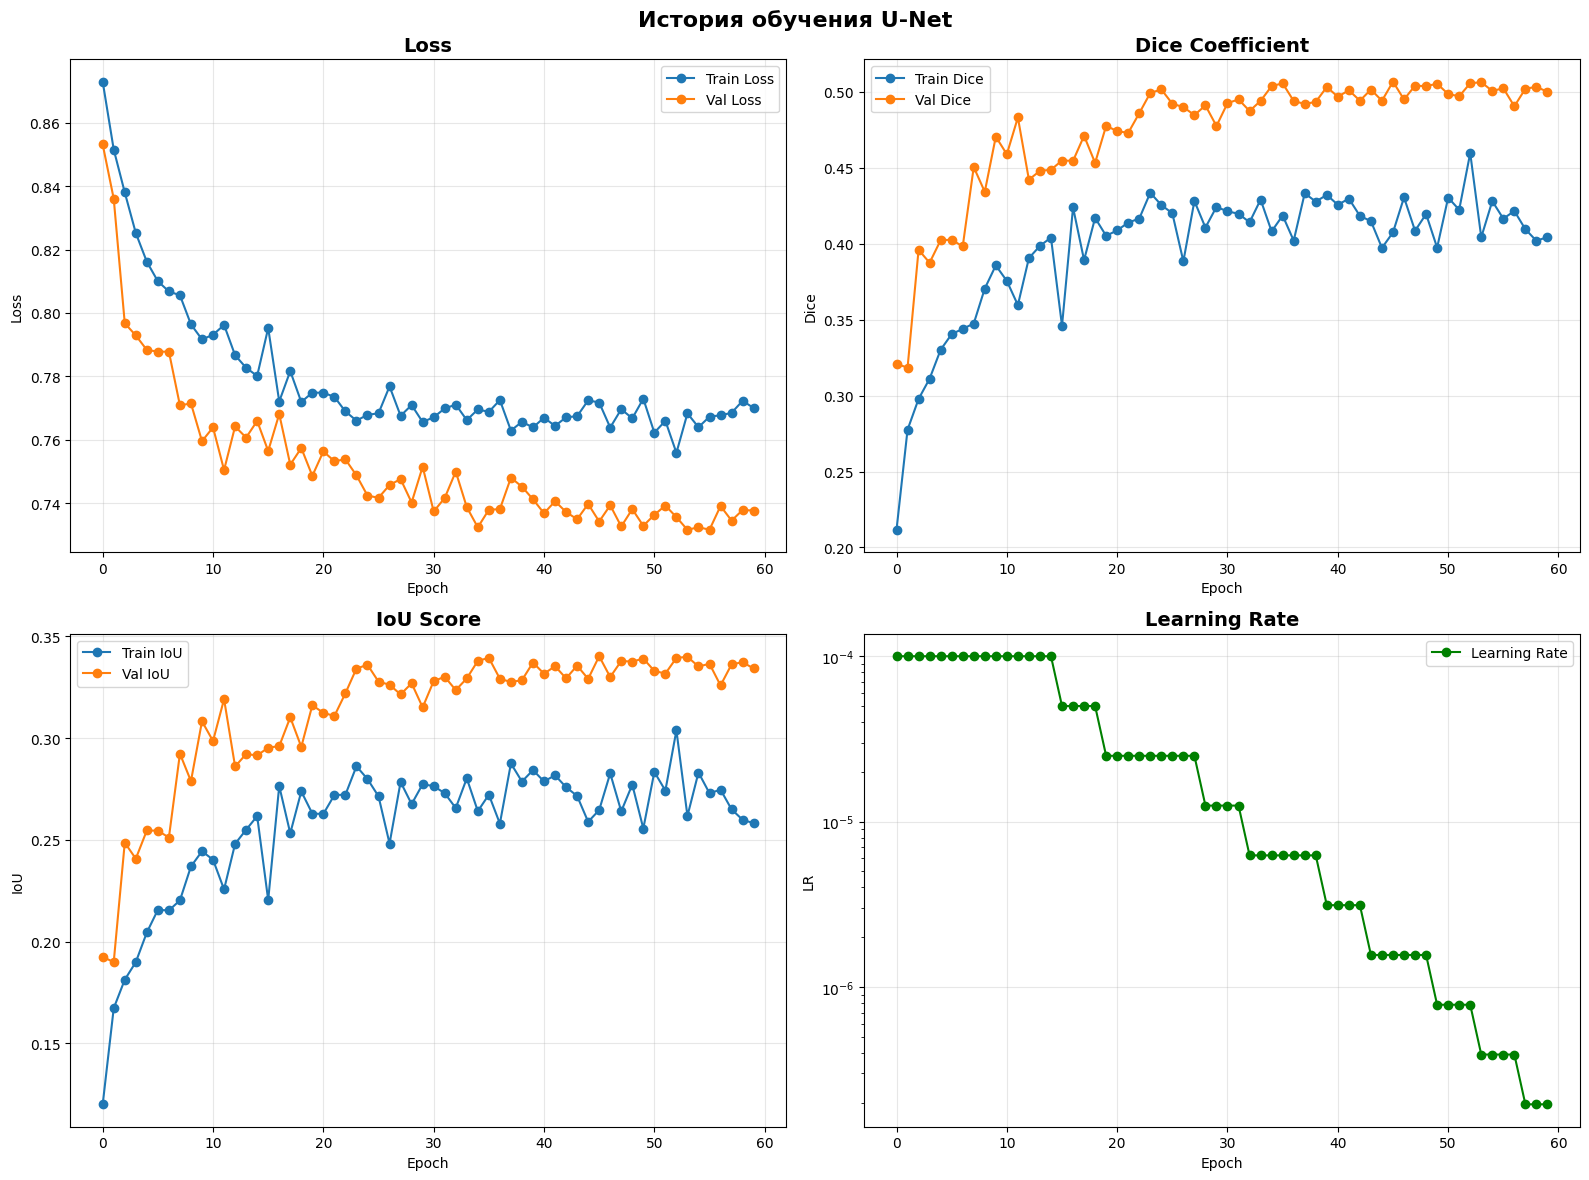

Train Loss: 0.7701
Val Loss: 0.7378
Train Dice: 0.4045
Val Dice: 0.5001
Train IoU: 0.2582
Val IoU: 0.3342
Val Accuracy: 0.8566


In [70]:
plot_training_history(history_resnet_unet_A)

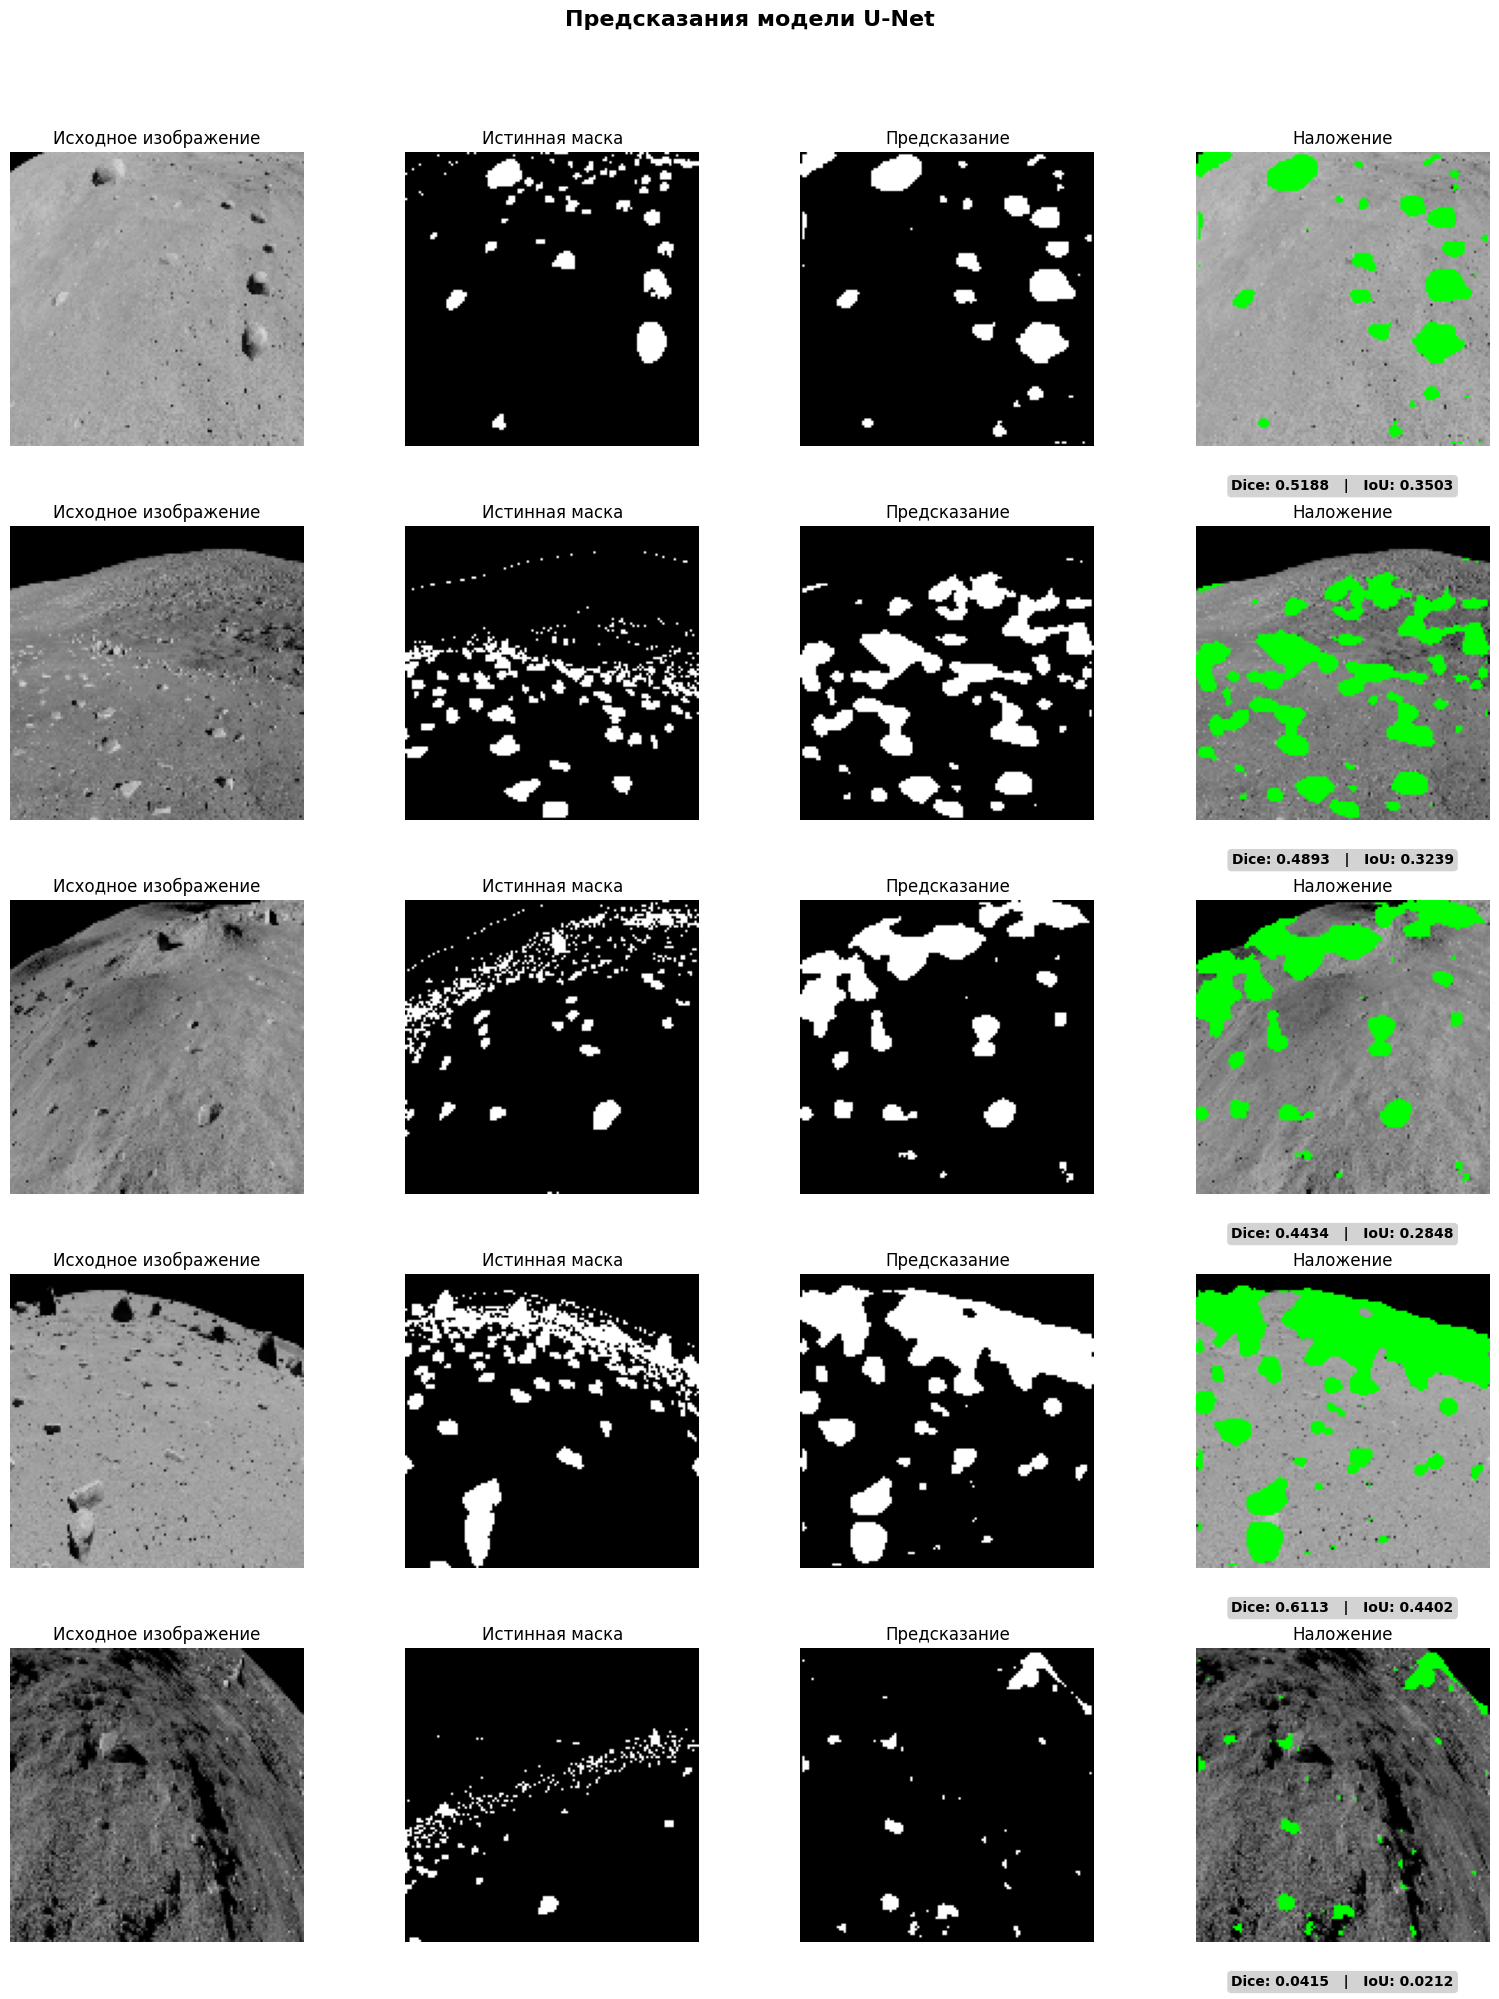

In [71]:
visualize_predictions(resnet_unetA, val_loader, device, num_samples=5)

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")
resnet_unetB = ResNetUNet(out_channels=1, state_dict=torch.load("model_resnet.pth", map_location=torch.device("cpu")))
for param in resnet_unetB.encoder_blocks.parameters():
  param.requires_grad = True
print(f"   Обучаемых параметров: {sum(p.numel() for p in resnet_unetB.parameters() if p.requires_grad):,}")

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
encoder_params = []
decoder_params = []
for name, param in resnet_unetB.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = torch.optim.Adam([{'params': encoder_params, 'lr': 1e-5}, {'params': decoder_params, 'lr': 1e-4}], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_resnet_unet_B = train_model(
    model=resnet_unetB,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_resnet_unet_B.pth'
)

  Используем устройство: cuda
Параметров: 4,663,457
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Обучаемых параметров: 4,663,457
Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.05it/s, loss=0.8479, dice=0.3193, iou=0.1900, acc=0.5880]



 Результаты эпохи 1:
  Train - Loss: 0.8687, Dice: 0.2327, IoU: 0.1360
  Val   - Loss: 0.8561, Dice: 0.3140, IoU: 0.1872, Acc: 0.6048
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3140
Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.72it/s, loss=0.8299, dice=0.3158, iou=0.1875, acc=0.5196]



 Результаты эпохи 2:
  Train - Loss: 0.8467, Dice: 0.3016, IoU: 0.1810
  Val   - Loss: 0.8403, Dice: 0.3161, IoU: 0.1885, Acc: 0.5555
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3161
Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s, loss=0.7941, dice=0.4843, iou=0.3195, acc=0.7895]



 Результаты эпохи 3:
  Train - Loss: 0.8358, Dice: 0.3152, IoU: 0.1927
  Val   - Loss: 0.8102, Dice: 0.4174, IoU: 0.2646, Acc: 0.7641
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4174
Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s, loss=0.7829, dice=0.5051, iou=0.3379, acc=0.8122]



 Результаты эпохи 4:
  Train - Loss: 0.8262, Dice: 0.3313, IoU: 0.2056
  Val   - Loss: 0.7981, Dice: 0.4449, IoU: 0.2875, Acc: 0.8055
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4449
Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s, loss=0.7801, dice=0.4860, iou=0.3210, acc=0.7911]



 Результаты эпохи 5:
  Train - Loss: 0.8227, Dice: 0.3362, IoU: 0.2078
  Val   - Loss: 0.7975, Dice: 0.4238, IoU: 0.2709, Acc: 0.7973
  LR: 0.000010
Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s, loss=0.7813, dice=0.5007, iou=0.3339, acc=0.8168]



 Результаты эпохи 6:
  Train - Loss: 0.8225, Dice: 0.3363, IoU: 0.2077
  Val   - Loss: 0.7958, Dice: 0.4442, IoU: 0.2879, Acc: 0.8214
  LR: 0.000010
Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s, loss=0.7851, dice=0.4619, iou=0.3003, acc=0.7576]



 Результаты эпохи 7:
  Train - Loss: 0.8145, Dice: 0.3564, IoU: 0.2241
  Val   - Loss: 0.7976, Dice: 0.4247, IoU: 0.2708, Acc: 0.7730
  LR: 0.000010
Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s, loss=0.7803, dice=0.4712, iou=0.3082, acc=0.7604]



 Результаты эпохи 8:
  Train - Loss: 0.8163, Dice: 0.3385, IoU: 0.2123
  Val   - Loss: 0.7935, Dice: 0.4318, IoU: 0.2762, Acc: 0.7704
  LR: 0.000005
Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s, loss=0.7753, dice=0.4846, iou=0.3198, acc=0.7838]



 Результаты эпохи 9:
  Train - Loss: 0.8095, Dice: 0.3596, IoU: 0.2271
  Val   - Loss: 0.7891, Dice: 0.4451, IoU: 0.2869, Acc: 0.7918
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4451
Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s, loss=0.7790, dice=0.4763, iou=0.3126, acc=0.7743]



 Результаты эпохи 10:
  Train - Loss: 0.8075, Dice: 0.3643, IoU: 0.2302
  Val   - Loss: 0.7933, Dice: 0.4306, IoU: 0.2761, Acc: 0.7762
  LR: 0.000005
Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s, loss=0.7801, dice=0.4621, iou=0.3004, acc=0.7768]



 Результаты эпохи 11:
  Train - Loss: 0.8037, Dice: 0.3808, IoU: 0.2436
  Val   - Loss: 0.7927, Dice: 0.4282, IoU: 0.2747, Acc: 0.7744
  LR: 0.000005
Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.96it/s, loss=0.7730, dice=0.4891, iou=0.3237, acc=0.7943]



 Результаты эпохи 12:
  Train - Loss: 0.8012, Dice: 0.3899, IoU: 0.2496
  Val   - Loss: 0.7854, Dice: 0.4473, IoU: 0.2893, Acc: 0.8050
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4473
Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s, loss=0.7723, dice=0.5035, iou=0.3364, acc=0.8017]



 Результаты эпохи 13:
  Train - Loss: 0.7937, Dice: 0.4111, IoU: 0.2631
  Val   - Loss: 0.7877, Dice: 0.4468, IoU: 0.2893, Acc: 0.7958
  LR: 0.000005
Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.99it/s, loss=0.7652, dice=0.5135, iou=0.3455, acc=0.8134]



 Результаты эпохи 14:
  Train - Loss: 0.7930, Dice: 0.4069, IoU: 0.2599
  Val   - Loss: 0.7801, Dice: 0.4601, IoU: 0.3002, Acc: 0.8232
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4601
Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.15it/s, loss=0.7671, dice=0.5081, iou=0.3406, acc=0.8183]



 Результаты эпохи 15:
  Train - Loss: 0.8033, Dice: 0.3745, IoU: 0.2362
  Val   - Loss: 0.7794, Dice: 0.4644, IoU: 0.3041, Acc: 0.8276
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4644
Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s, loss=0.7672, dice=0.5008, iou=0.3340, acc=0.8099]



 Результаты эпохи 16:
  Train - Loss: 0.7904, Dice: 0.4138, IoU: 0.2669
  Val   - Loss: 0.7780, Dice: 0.4670, IoU: 0.3061, Acc: 0.8248
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4670
Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s, loss=0.7625, dice=0.5085, iou=0.3409, acc=0.8109]



 Результаты эпохи 17:
  Train - Loss: 0.7940, Dice: 0.3987, IoU: 0.2555
  Val   - Loss: 0.7745, Dice: 0.4668, IoU: 0.3055, Acc: 0.8268
  LR: 0.000005
Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.21it/s, loss=0.7679, dice=0.4887, iou=0.3233, acc=0.7857]



 Результаты эпохи 18:
  Train - Loss: 0.7910, Dice: 0.4083, IoU: 0.2624
  Val   - Loss: 0.7823, Dice: 0.4401, IoU: 0.2839, Acc: 0.7863
  LR: 0.000005
Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.7577, dice=0.5121, iou=0.3442, acc=0.8135]



 Результаты эпохи 19:
  Train - Loss: 0.7901, Dice: 0.4003, IoU: 0.2573
  Val   - Loss: 0.7680, Dice: 0.4769, IoU: 0.3138, Acc: 0.8342
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4769
Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.89it/s, loss=0.7568, dice=0.5222, iou=0.3534, acc=0.8227]



 Результаты эпохи 20:
  Train - Loss: 0.7934, Dice: 0.3863, IoU: 0.2508
  Val   - Loss: 0.7705, Dice: 0.4689, IoU: 0.3077, Acc: 0.8186
  LR: 0.000005
Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s, loss=0.7663, dice=0.4827, iou=0.3181, acc=0.7860]



 Результаты эпохи 21:
  Train - Loss: 0.7893, Dice: 0.3944, IoU: 0.2547
  Val   - Loss: 0.7730, Dice: 0.4572, IoU: 0.2977, Acc: 0.8004
  LR: 0.000005
Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s, loss=0.7585, dice=0.5052, iou=0.3379, acc=0.8170]



 Результаты эпохи 22:
  Train - Loss: 0.7881, Dice: 0.4014, IoU: 0.2605
  Val   - Loss: 0.7679, Dice: 0.4720, IoU: 0.3105, Acc: 0.8207
  LR: 0.000005
Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s, loss=0.7481, dice=0.5303, iou=0.3608, acc=0.8416]



 Результаты эпохи 23:
  Train - Loss: 0.7793, Dice: 0.4286, IoU: 0.2800
  Val   - Loss: 0.7613, Dice: 0.4890, IoU: 0.3247, Acc: 0.8432
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4890
Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s, loss=0.7479, dice=0.5395, iou=0.3693, acc=0.8400]



 Результаты эпохи 24:
  Train - Loss: 0.7779, Dice: 0.4281, IoU: 0.2814
  Val   - Loss: 0.7641, Dice: 0.4792, IoU: 0.3165, Acc: 0.8304
  LR: 0.000005
Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s, loss=0.7363, dice=0.5520, iou=0.3812, acc=0.8557]



 Результаты эпохи 25:
  Train - Loss: 0.7876, Dice: 0.3994, IoU: 0.2586
  Val   - Loss: 0.7554, Dice: 0.4835, IoU: 0.3208, Acc: 0.8487
  LR: 0.000005
Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.77it/s, loss=0.7348, dice=0.5447, iou=0.3743, acc=0.8619]



 Результаты эпохи 26:
  Train - Loss: 0.7893, Dice: 0.3803, IoU: 0.2415
  Val   - Loss: 0.7520, Dice: 0.4909, IoU: 0.3266, Acc: 0.8663
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4909
Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s, loss=0.7406, dice=0.5350, iou=0.3652, acc=0.8416]



 Результаты эпохи 27:
  Train - Loss: 0.7922, Dice: 0.3699, IoU: 0.2356
  Val   - Loss: 0.7561, Dice: 0.4733, IoU: 0.3113, Acc: 0.8422
  LR: 0.000005
Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.86it/s, loss=0.7393, dice=0.5339, iou=0.3642, acc=0.8287]



 Результаты эпохи 28:
  Train - Loss: 0.7832, Dice: 0.4025, IoU: 0.2617
  Val   - Loss: 0.7544, Dice: 0.4703, IoU: 0.3085, Acc: 0.8376
  LR: 0.000005
Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s, loss=0.7320, dice=0.5448, iou=0.3744, acc=0.8511]



 Результаты эпохи 29:
  Train - Loss: 0.7826, Dice: 0.3923, IoU: 0.2509
  Val   - Loss: 0.7495, Dice: 0.4740, IoU: 0.3125, Acc: 0.8569
  LR: 0.000005
Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.61it/s, loss=0.7366, dice=0.5473, iou=0.3767, acc=0.8468]



 Результаты эпохи 30:
  Train - Loss: 0.7904, Dice: 0.3661, IoU: 0.2368
  Val   - Loss: 0.7539, Dice: 0.4814, IoU: 0.3184, Acc: 0.8480
  LR: 0.000003
Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s, loss=0.7322, dice=0.5474, iou=0.3768, acc=0.8626]



 Результаты эпохи 31:
  Train - Loss: 0.7767, Dice: 0.4209, IoU: 0.2746
  Val   - Loss: 0.7478, Dice: 0.4863, IoU: 0.3232, Acc: 0.8692
  LR: 0.000003
Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s, loss=0.7354, dice=0.5431, iou=0.3728, acc=0.8567]



 Результаты эпохи 32:
  Train - Loss: 0.7761, Dice: 0.4273, IoU: 0.2810
  Val   - Loss: 0.7486, Dice: 0.4916, IoU: 0.3274, Acc: 0.8704
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4916
Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s, loss=0.7349, dice=0.5456, iou=0.3751, acc=0.8544]



 Результаты эпохи 33:
  Train - Loss: 0.7764, Dice: 0.4149, IoU: 0.2691
  Val   - Loss: 0.7486, Dice: 0.4919, IoU: 0.3275, Acc: 0.8650
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4919
Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s, loss=0.7349, dice=0.5432, iou=0.3729, acc=0.8470]



 Результаты эпохи 34:
  Train - Loss: 0.7799, Dice: 0.4039, IoU: 0.2604
  Val   - Loss: 0.7519, Dice: 0.4753, IoU: 0.3138, Acc: 0.8535
  LR: 0.000003
Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s, loss=0.7271, dice=0.5517, iou=0.3809, acc=0.8530]



 Результаты эпохи 35:
  Train - Loss: 0.7792, Dice: 0.4040, IoU: 0.2656
  Val   - Loss: 0.7463, Dice: 0.4812, IoU: 0.3186, Acc: 0.8592
  LR: 0.000003
Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s, loss=0.7346, dice=0.5477, iou=0.3771, acc=0.8497]



 Результаты эпохи 36:
  Train - Loss: 0.7686, Dice: 0.4429, IoU: 0.2914
  Val   - Loss: 0.7523, Dice: 0.4812, IoU: 0.3189, Acc: 0.8542
  LR: 0.000003
Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s, loss=0.7317, dice=0.5583, iou=0.3873, acc=0.8579]



 Результаты эпохи 37:
  Train - Loss: 0.7769, Dice: 0.4084, IoU: 0.2677
  Val   - Loss: 0.7478, Dice: 0.4979, IoU: 0.3334, Acc: 0.8665
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4979
Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s, loss=0.7382, dice=0.5432, iou=0.3729, acc=0.8407]



 Результаты эпохи 38:
  Train - Loss: 0.7795, Dice: 0.3958, IoU: 0.2546
  Val   - Loss: 0.7533, Dice: 0.4833, IoU: 0.3202, Acc: 0.8455
  LR: 0.000003
Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.17it/s, loss=0.7335, dice=0.5477, iou=0.3771, acc=0.8597]



 Результаты эпохи 39:
  Train - Loss: 0.7690, Dice: 0.4341, IoU: 0.2848
  Val   - Loss: 0.7486, Dice: 0.4894, IoU: 0.3258, Acc: 0.8652
  LR: 0.000003
Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s, loss=0.7242, dice=0.5625, iou=0.3913, acc=0.8572]



 Результаты эпохи 40:
  Train - Loss: 0.7774, Dice: 0.4070, IoU: 0.2640
  Val   - Loss: 0.7413, Dice: 0.4973, IoU: 0.3324, Acc: 0.8696
  LR: 0.000003
Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.81it/s, loss=0.7272, dice=0.5590, iou=0.3879, acc=0.8536]



 Результаты эпохи 41:
  Train - Loss: 0.7728, Dice: 0.4201, IoU: 0.2757
  Val   - Loss: 0.7454, Dice: 0.4896, IoU: 0.3260, Acc: 0.8635
  LR: 0.000001
Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s, loss=0.7255, dice=0.5690, iou=0.3976, acc=0.8536]



 Результаты эпохи 42:
  Train - Loss: 0.7724, Dice: 0.4229, IoU: 0.2788
  Val   - Loss: 0.7446, Dice: 0.5033, IoU: 0.3374, Acc: 0.8570
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.5033
Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s, loss=0.7235, dice=0.5740, iou=0.4025, acc=0.8642]



 Результаты эпохи 43:
  Train - Loss: 0.7646, Dice: 0.4527, IoU: 0.2996
  Val   - Loss: 0.7442, Dice: 0.4974, IoU: 0.3330, Acc: 0.8682
  LR: 0.000001
Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.80it/s, loss=0.7221, dice=0.5769, iou=0.4054, acc=0.8627]



 Результаты эпохи 44:
  Train - Loss: 0.7747, Dice: 0.4157, IoU: 0.2691
  Val   - Loss: 0.7433, Dice: 0.4970, IoU: 0.3328, Acc: 0.8667
  LR: 0.000001
Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s, loss=0.7274, dice=0.5650, iou=0.3937, acc=0.8506]



 Результаты эпохи 45:
  Train - Loss: 0.7660, Dice: 0.4363, IoU: 0.2905
  Val   - Loss: 0.7469, Dice: 0.4896, IoU: 0.3262, Acc: 0.8546
  LR: 0.000001
Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s, loss=0.7232, dice=0.5629, iou=0.3917, acc=0.8467]



 Результаты эпохи 46:
  Train - Loss: 0.7725, Dice: 0.4201, IoU: 0.2792
  Val   - Loss: 0.7405, Dice: 0.4991, IoU: 0.3335, Acc: 0.8567
  LR: 0.000001
Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s, loss=0.7262, dice=0.5661, iou=0.3948, acc=0.8557]



 Результаты эпохи 47:
  Train - Loss: 0.7666, Dice: 0.4408, IoU: 0.2920
  Val   - Loss: 0.7430, Dice: 0.5011, IoU: 0.3361, Acc: 0.8622
  LR: 0.000001
Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s, loss=0.7235, dice=0.5706, iou=0.3992, acc=0.8670]



 Результаты эпохи 48:
  Train - Loss: 0.7678, Dice: 0.4259, IoU: 0.2761
  Val   - Loss: 0.7410, Dice: 0.5084, IoU: 0.3426, Acc: 0.8719
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.5084
Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s, loss=0.7236, dice=0.5652, iou=0.3939, acc=0.8652]



 Результаты эпохи 49:
  Train - Loss: 0.7650, Dice: 0.4367, IoU: 0.2884
  Val   - Loss: 0.7404, Dice: 0.5010, IoU: 0.3361, Acc: 0.8721
  LR: 0.000001
Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.44it/s, loss=0.7230, dice=0.5672, iou=0.3959, acc=0.8578]



 Результаты эпохи 50:
  Train - Loss: 0.7691, Dice: 0.4256, IoU: 0.2791
  Val   - Loss: 0.7399, Dice: 0.4994, IoU: 0.3349, Acc: 0.8627
  LR: 0.000001
Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.7220, dice=0.5764, iou=0.4049, acc=0.8648]



 Результаты эпохи 51:
  Train - Loss: 0.7658, Dice: 0.4352, IoU: 0.2904
  Val   - Loss: 0.7403, Dice: 0.5040, IoU: 0.3388, Acc: 0.8719
  LR: 0.000001
Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s, loss=0.7297, dice=0.5628, iou=0.3916, acc=0.8510]



 Результаты эпохи 52:
  Train - Loss: 0.7623, Dice: 0.4488, IoU: 0.3002
  Val   - Loss: 0.7477, Dice: 0.4930, IoU: 0.3297, Acc: 0.8536
  LR: 0.000000
Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s, loss=0.7331, dice=0.5556, iou=0.3847, acc=0.8494]



 Результаты эпохи 53:
  Train - Loss: 0.7682, Dice: 0.4317, IoU: 0.2825
  Val   - Loss: 0.7513, Dice: 0.4871, IoU: 0.3243, Acc: 0.8505
  LR: 0.000000
Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s, loss=0.7208, dice=0.5716, iou=0.4001, acc=0.8582]



 Результаты эпохи 54:
  Train - Loss: 0.7682, Dice: 0.4199, IoU: 0.2734
  Val   - Loss: 0.7386, Dice: 0.5014, IoU: 0.3363, Acc: 0.8670
  LR: 0.000000
Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.91it/s, loss=0.7233, dice=0.5701, iou=0.3987, acc=0.8583]



 Результаты эпохи 55:
  Train - Loss: 0.7613, Dice: 0.4506, IoU: 0.2955
  Val   - Loss: 0.7410, Dice: 0.5005, IoU: 0.3355, Acc: 0.8668
  LR: 0.000000
Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s, loss=0.7245, dice=0.5692, iou=0.3978, acc=0.8545]



 Результаты эпохи 56:
  Train - Loss: 0.7626, Dice: 0.4483, IoU: 0.2956
  Val   - Loss: 0.7421, Dice: 0.4998, IoU: 0.3349, Acc: 0.8630
  LR: 0.000000
Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s, loss=0.7209, dice=0.5687, iou=0.3973, acc=0.8536]



 Результаты эпохи 57:
  Train - Loss: 0.7731, Dice: 0.4110, IoU: 0.2659
  Val   - Loss: 0.7383, Dice: 0.4992, IoU: 0.3342, Acc: 0.8663
  LR: 0.000000
Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.7270, dice=0.5630, iou=0.3918, acc=0.8489]



 Результаты эпохи 58:
  Train - Loss: 0.7680, Dice: 0.4247, IoU: 0.2819
  Val   - Loss: 0.7452, Dice: 0.4919, IoU: 0.3281, Acc: 0.8564
  LR: 0.000000
Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s, loss=0.7224, dice=0.5693, iou=0.3979, acc=0.8562]



 Результаты эпохи 59:
  Train - Loss: 0.7642, Dice: 0.4460, IoU: 0.2964
  Val   - Loss: 0.7405, Dice: 0.4968, IoU: 0.3323, Acc: 0.8675
  LR: 0.000000
Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s, loss=0.7196, dice=0.5663, iou=0.3950, acc=0.8548]


 Результаты эпохи 60:
  Train - Loss: 0.7695, Dice: 0.4220, IoU: 0.2760
  Val   - Loss: 0.7378, Dice: 0.4937, IoU: 0.3293, Acc: 0.8690
  LR: 0.000000
Лучший Val Dice: 0.5084


**Результы обучения U-Net с бэкбоном из ResNet с разморозкой:** на 48 эпохе модель достигла на валидации Dice = 0.5084, IoU = 0.3426, Pixel Acc = 0.8719

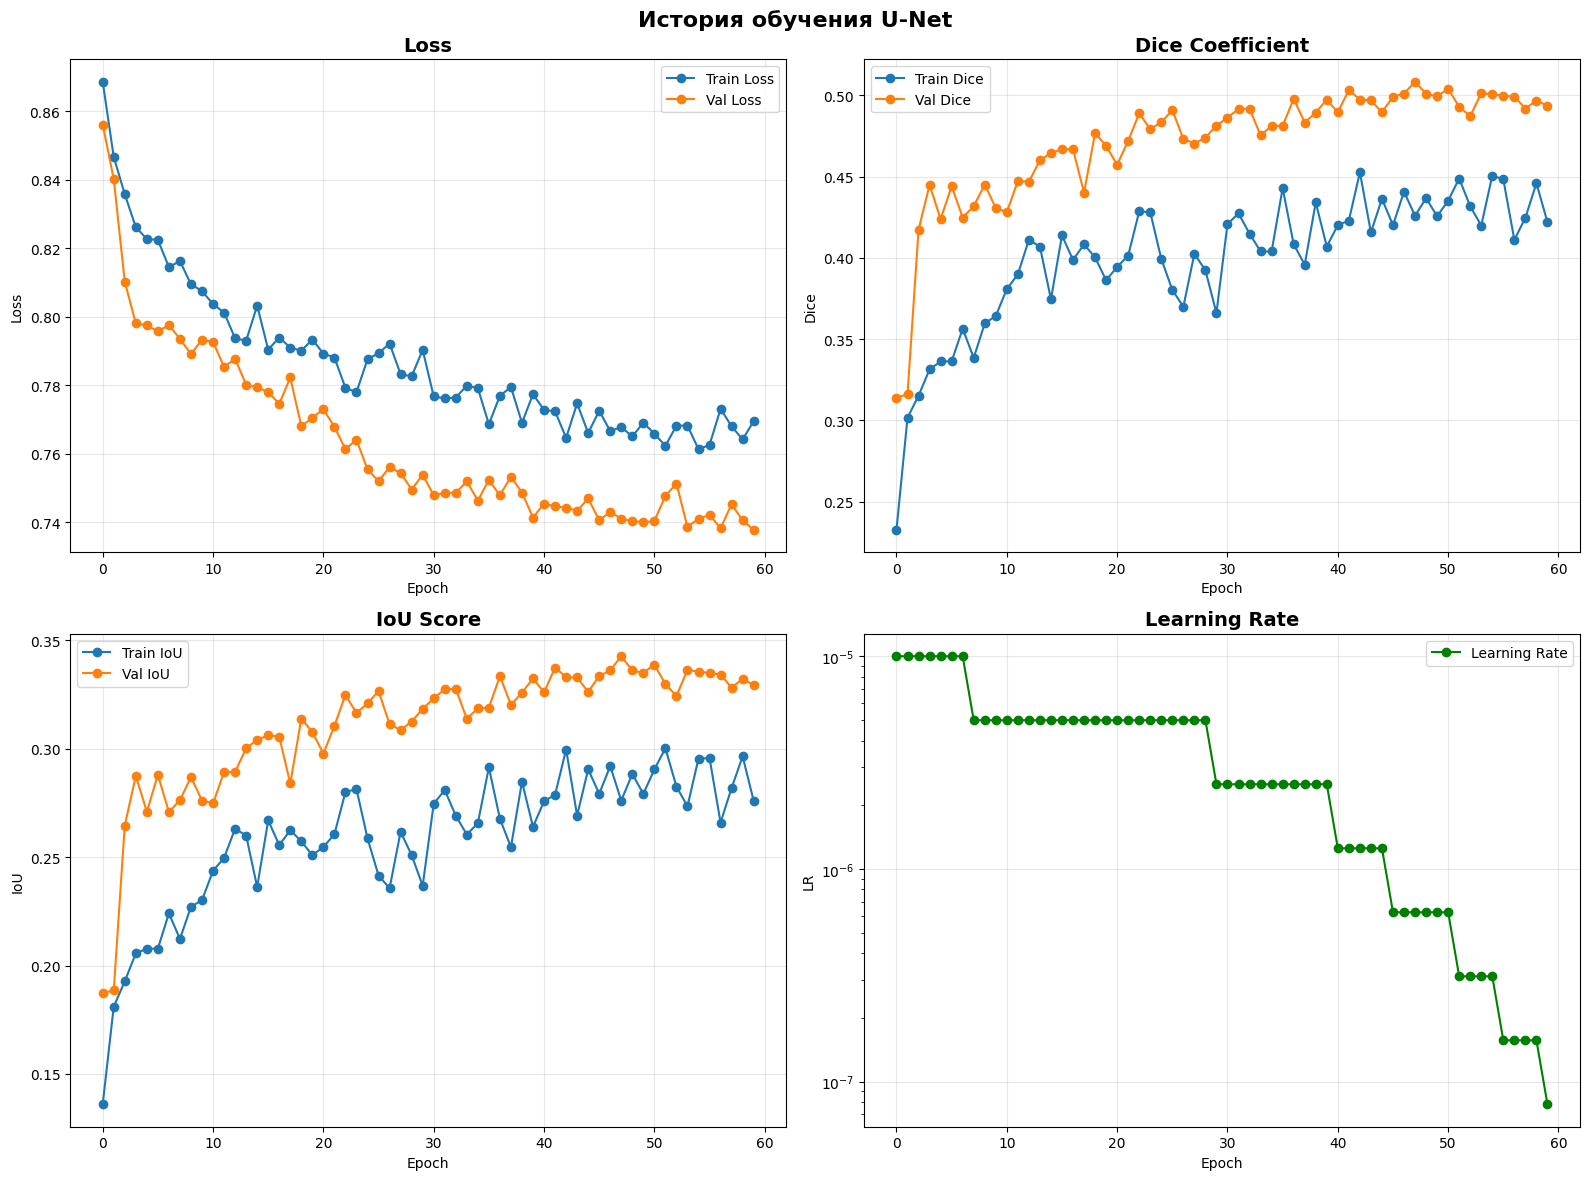

Train Loss: 0.7695
Val Loss: 0.7378
Train Dice: 0.4220
Val Dice: 0.4937
Train IoU: 0.2760
Val IoU: 0.3293
Val Accuracy: 0.8690


In [73]:
plot_training_history(history_resnet_unet_B)

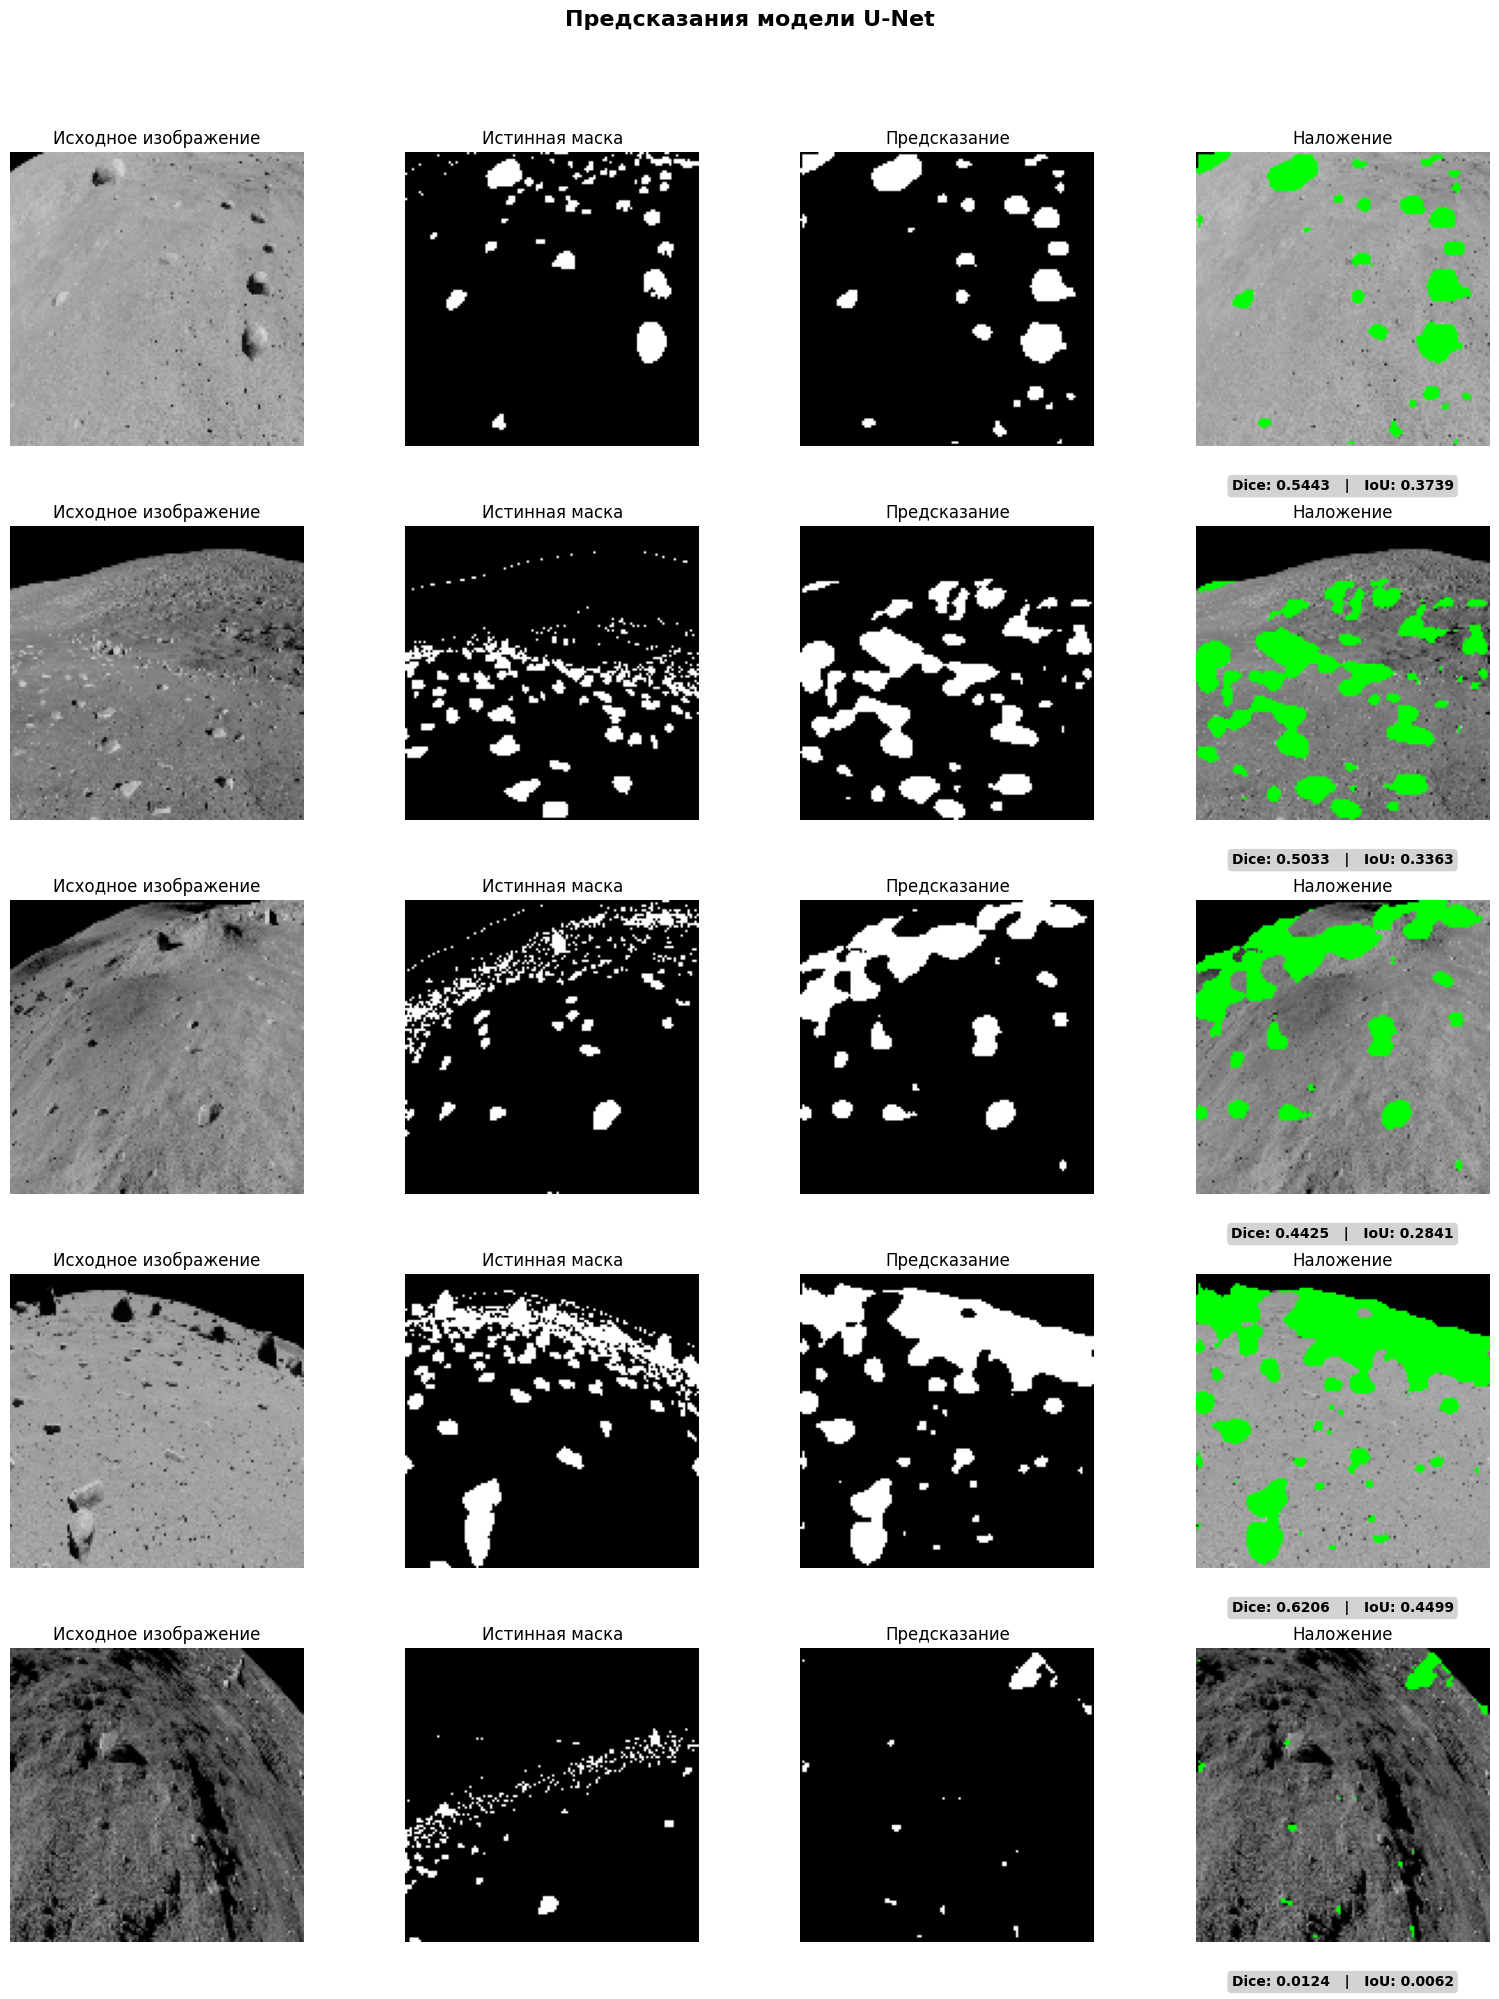

In [74]:
visualize_predictions(resnet_unetB, val_loader, device, num_samples=5)

In [78]:
def compare_models(simple_model, resnet_model, dataloader, device, num_samples=3, names=["U-Net", "ResNet-UNet"]):

    simple_model.eval()
    resnet_model.eval()

    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        simple_preds = simple_model(images)
        simple_preds = (simple_preds > 0.5).float()

        resnet_preds = resnet_model(images)
        resnet_preds = (resnet_preds > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    simple_preds = simple_preds.cpu()
    resnet_preds = resnet_preds.cpu()

    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        if masks.dim() == 4:  # [B, 1, H, W]
          mask_true = masks[i, 0].numpy()
        elif masks.dim() == 3:  # [B, H, W]
          mask_true = masks[i].numpy()
        #mask_true = masks[i, 0].numpy()
        simple_pred = simple_preds[i, 0].numpy()
        resnet_pred = resnet_preds[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(simple_pred, cmap='gray')
        simple_dice = dice_coefficient(simple_preds[i:i+1], masks[i:i+1])
        simple_iou = iou_score(simple_preds[i:i+1], masks[i:i+1])
        axes[i, 2].set_title(f'{names[0]} \nDice: {simple_dice:.3f} | IoU: {simple_iou:.3f}', fontsize=10)
        axes[i, 2].axis('off')

        axes[i, 3].imshow(resnet_pred, cmap='gray')
        resnet_dice = dice_coefficient(resnet_preds[i:i+1], masks[i:i+1])
        resnet_iou = iou_score(resnet_preds[i:i+1], masks[i:i+1])
        axes[i, 3].set_title(f'{names[1]}\nDice: {resnet_dice:.3f} | IoU: {resnet_iou:.3f}', fontsize=10)
        axes[i, 3].axis('off')

        diff = np.abs(simple_pred - resnet_pred)
        axes[i, 4].imshow(diff, cmap='hot')
        axes[i, 4].set_title('Difference\n(white = disagree)', fontsize=10)
        axes[i, 4].axis('off')

    plt.suptitle(f'Сравнение моделей {names[0]} и {names[1]}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



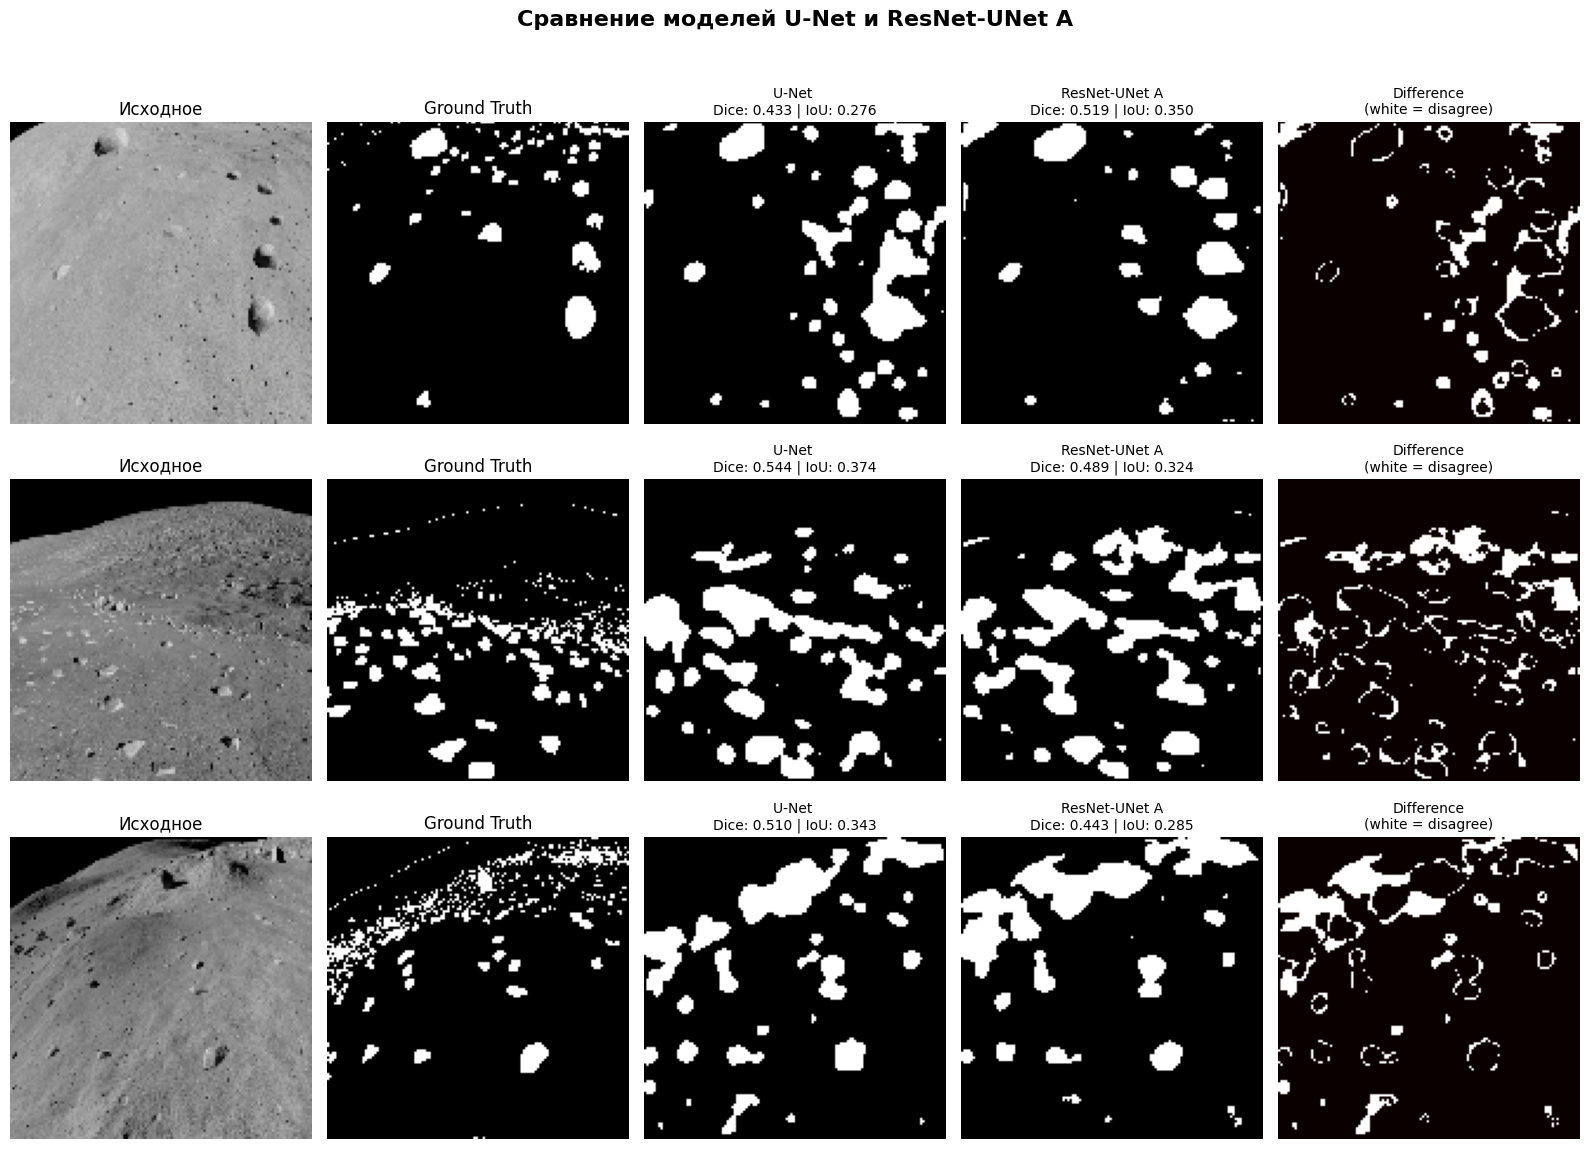

In [79]:
compare_models(unet_model, resnet_unetA, val_loader, device, num_samples=3, names=["U-Net", "ResNet-UNet A"])

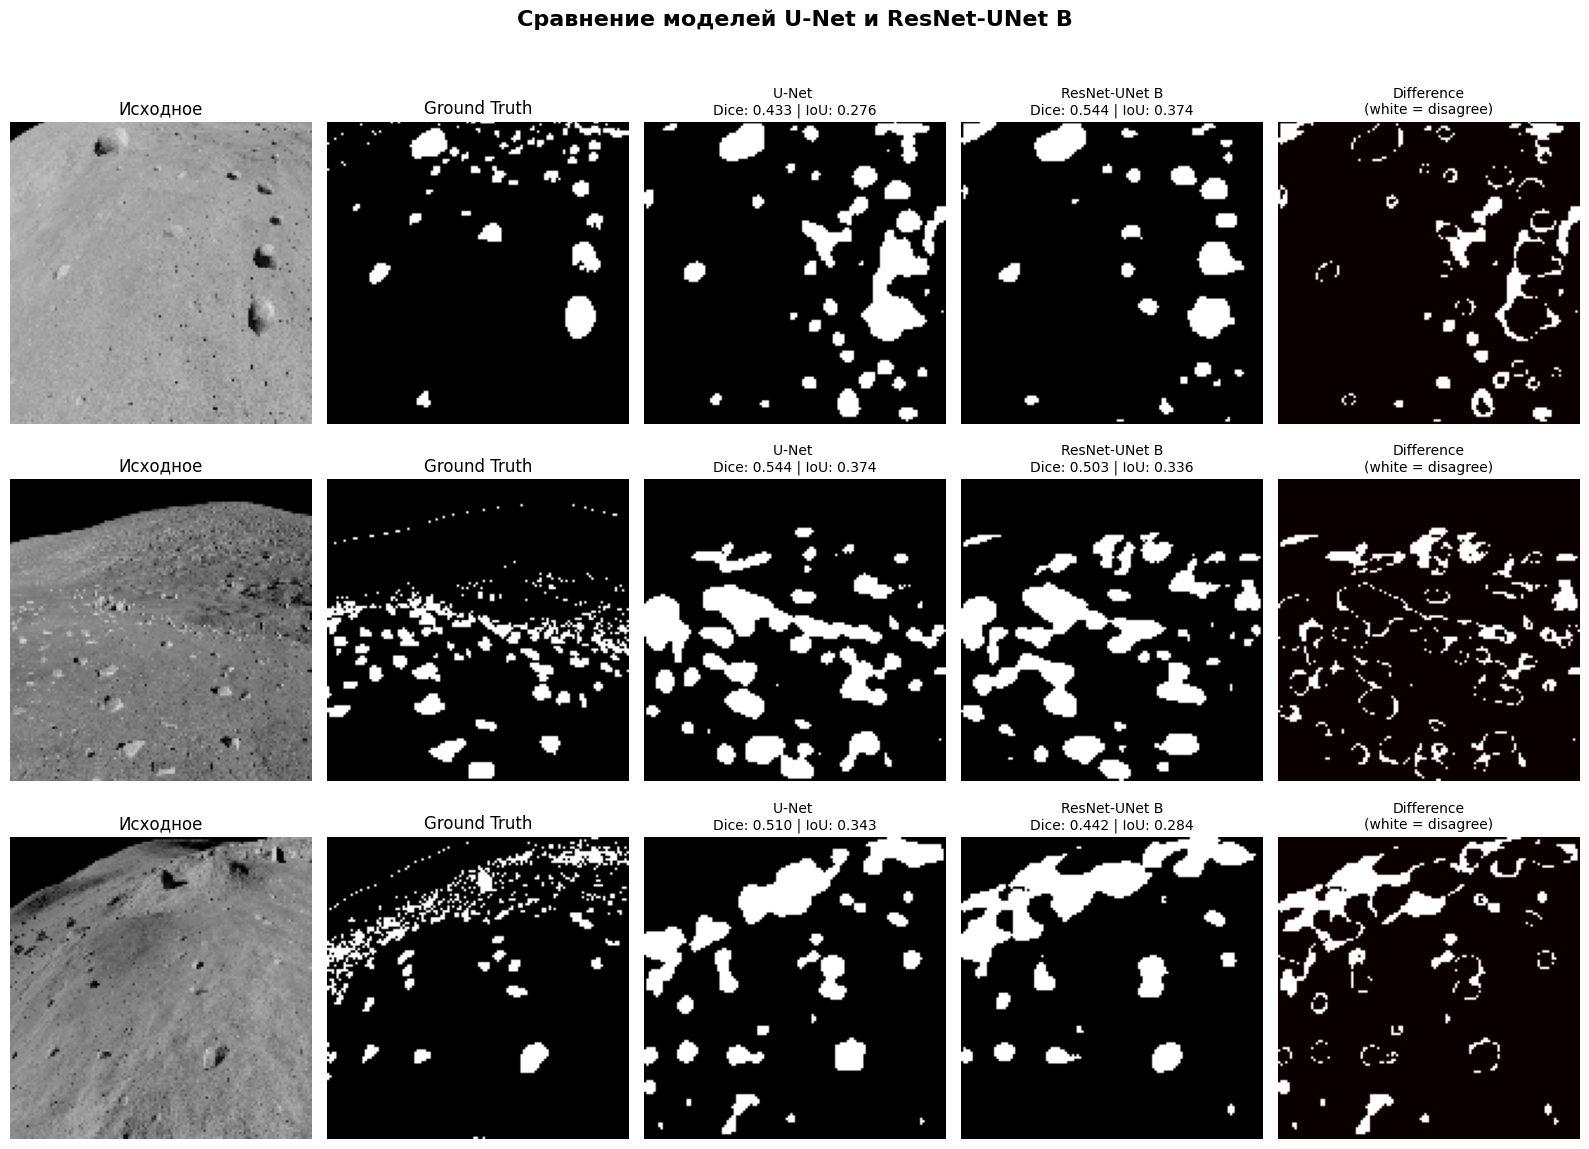

In [80]:
compare_models(unet_model, resnet_unetB, val_loader, device, num_samples=3, names=["U-Net", "ResNet-UNet B"])

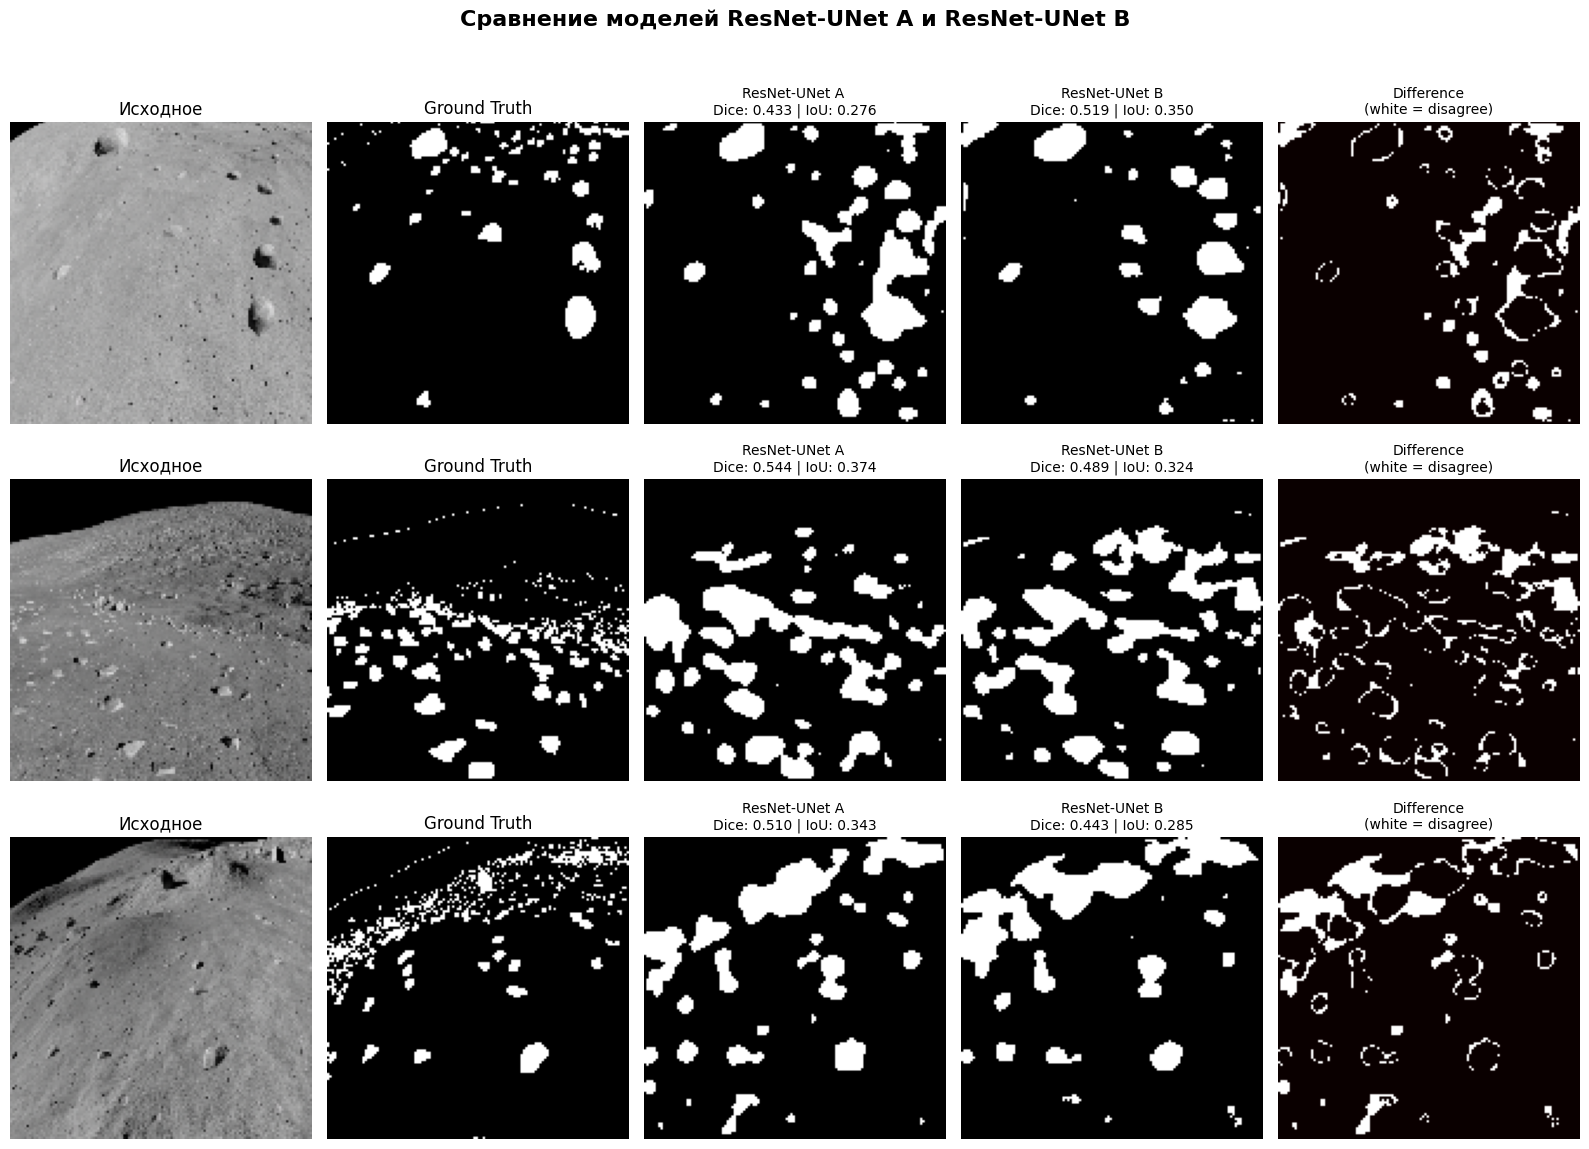

In [81]:
compare_models(unet_model, resnet_unetA, val_loader, device, num_samples=3, names=["ResNet-UNet A", "ResNet-UNet B"])

### Результат

| Конфигурация                | Всего параметров | Обучаемых |Val IoU | Val Dice |Val Pixel Acc|
|-----------------------------|------------------|-----------|---------|----------|-------------|
| Базовая U-Net               | 2.47M            | 2.47M     | **0.3666**     |**0.5355**        |**0.8806**|
| U-Net + Resnet с заморозкой | 4.66M            | 3.47M     | 0.3402     |0.5067|0.8614|
| U-Net + Resnet с разморозкой| 4.66M            | 4.66M     | 0.3426     |0.5084|0.8719|

**Вывод:** лучший результат по всем метрикам на валидации показала базовая модель Unet.

Это объяснимо, так как датасет "Луна" содержит всего 100 изображений (80 трейн / 20 валидация) и на таком маленьком датасете предобученный бэкбон может не адаптироваться достаточно хорошо, особенно если его признаки, обученные на другом домене, мало релевантны задаче сегментации лунного грунта и камней. В то время как базовая U-Net обучалась с нуля и специализировалась именно на этих данных.

Если сравнивать модели с бэкбоном, то при разморозке энкодера модель показывает лучше результат, так как она смогла немного адаптироваться к домену.